# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
#increase the number of rows and columns displayed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
customer = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\82151\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
azdias.shape # 891221 rows and 366 columns

(891221, 366)

In [6]:
customer.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
customer.shape # 191652 rows and 369 columns

(191652, 369)

### Preprocess the data
Since the first column "LNR" can be seen as the unique ID for each individual, I set it as the index.

In [8]:
azdias.set_index("LNR", inplace=True)

In [9]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

#### Deal with missing values

1. For some columns, the unknown values are encoding as -1 or 0. These values are actually missing values and should be converted to numpy.NaN.

In [10]:
azdias.AGER_TYP.value_counts() #-1 means unknown

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [11]:
#load in the descriptions of each column to see which columns contain "unknown" value
attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1, usecols = "B:E")
attributes.ffill(inplace=True)
attributes.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [12]:
unknown_values = attributes.loc[attributes.Meaning.str.contains("unknown")]
unknown_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [13]:
#convert all the "unknown" into np.nan
for index, row in unknown_values.iterrows():
    attribute = row["Attribute"]
    values = row["Value"]
    
    value_list = []
    if type(values) != int:
        value_list = values.split(",")
    else:
        value_list.append(values)
    
    for i in value_list:
        azdias[attribute] = azdias[attribute].replace(int(i), np.nan)

2. We need to look at the data type of each column to ensure there are not invalid data types, which should also be treated as missing values.

In [14]:
azdias.dtypes

AGER_TYP                       float64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                

Most of the columns are either int or float. This is in line with the descriptions of the attributes. We need to look at the columns that have a data type of "object" to make sure they are in the right data type.

In [15]:
azdias.columns[azdias.dtypes == "object"]

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [16]:
#look at the values in CAMEO_DEU_2015
azdias.CAMEO_DEU_2015.value_counts().sort_index()

1A    10850
1B     4071
1C     4317
1D    11909
1E     5065
2A    13249
2B    15486
2C    19422
2D    35074
3A    10543
3B     7160
3C    34769
3D    34307
4A    33155
4B     9047
4C    47819
4D     8570
4E     5321
5A    12214
5B    10354
5C     9935
5D    14943
5E     3581
5F     4283
6A     6810
6B    56672
6C    14820
6D     6073
6E    16107
6F     5392
7A    34399
7B    24503
7C     9065
7D     5333
7E     4633
8A    52438
8B    33434
8C    30993
8D    17576
9A    20542
9B    27676
9C    24987
9D    28593
9E     6379
XX      373
Name: CAMEO_DEU_2015, dtype: int64

"XX" is not a valid value in this column. It should be converted to np.NaN.

In [17]:
azdias["CAMEO_DEU_2015"] = azdias["CAMEO_DEU_2015"].replace("XX", np.nan)

In [18]:
azdias.CAMEO_DEU_2015.value_counts().sort_index() # check if all converted

1A    10850
1B     4071
1C     4317
1D    11909
1E     5065
2A    13249
2B    15486
2C    19422
2D    35074
3A    10543
3B     7160
3C    34769
3D    34307
4A    33155
4B     9047
4C    47819
4D     8570
4E     5321
5A    12214
5B    10354
5C     9935
5D    14943
5E     3581
5F     4283
6A     6810
6B    56672
6C    14820
6D     6073
6E    16107
6F     5392
7A    34399
7B    24503
7C     9065
7D     5333
7E     4633
8A    52438
8B    33434
8C    30993
8D    17576
9A    20542
9B    27676
9C    24987
9D    28593
9E     6379
Name: CAMEO_DEU_2015, dtype: int64

In [19]:
#look at the values in CAMEO_DEUG_2015
azdias.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

"X" is not a valid value in this column. It should be converted to np.NaN. Besides, this column contains values of different types, so all the numbers should be converted to int.

In [20]:
azdias["CAMEO_DEUG_2015"] = azdias["CAMEO_DEUG_2015"].replace("X", np.nan) # convert X to NaN

In [21]:
azdias.CAMEO_DEUG_2015 = azdias.CAMEO_DEUG_2015.apply(lambda x: float(x)) # convert to the same data type

In [22]:
azdias.CAMEO_DEUG_2015.value_counts().sort_index() # check if all converted

1.0     36212
2.0     83231
3.0     86779
4.0    103912
5.0     55310
6.0    105874
7.0     77933
8.0    134441
9.0    108177
Name: CAMEO_DEUG_2015, dtype: int64

In [23]:
#look at the values in CAMEO_DEUG_2015
azdias.CAMEO_INTL_2015.value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

This column has the same issue as the previous column.

In [24]:
azdias["CAMEO_INTL_2015"] = azdias.CAMEO_INTL_2015.replace("XX", np.nan) # convert X to NaN
azdias.CAMEO_INTL_2015 = azdias.CAMEO_INTL_2015.apply(lambda x: float(x)) # convert to the same data type
azdias.CAMEO_INTL_2015.value_counts().sort_index() # check if all converted

12.0     13249
13.0     26336
14.0     62884
15.0     16974
22.0     33155
23.0     26750
24.0     91158
25.0     39628
31.0     19024
32.0     10354
33.0      9935
34.0     18524
35.0     10356
41.0     92336
43.0     56672
44.0     14820
45.0     26132
51.0    133694
52.0     20542
54.0     45391
55.0     23955
Name: CAMEO_INTL_2015, dtype: int64

In [25]:
#look at the values in CAMEO_DEUG_2015
azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()

D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN                  1646
D19_BANKEN

Since all the values are string, this column should be "object". No need to convert.

In [26]:
#look at the values in CAMEO_DEUG_2015
azdias.EINGEFUEGT_AM.value_counts()

1992-02-10 00:00:00    383738
1992-02-12 00:00:00    192264
1995-02-07 00:00:00     11181
2005-12-16 00:00:00      6291
2003-11-18 00:00:00      6050
                        ...  
2008-03-20 00:00:00         1
2004-05-02 00:00:00         1
1999-10-07 00:00:00         1
2015-08-19 00:00:00         1
2015-06-12 00:00:00         1
Name: EINGEFUEGT_AM, Length: 5162, dtype: int64

This column represents the time inserted and should be converted to datetime format. But since this variable doesn't contain useful information to classify the customers, I decide to drop this column.

In [27]:
azdias.drop("EINGEFUEGT_AM", axis=1, inplace=True)
azdias.shape

(891221, 364)

In [28]:
#look at the values in CAMEO_DEUG_2015
azdias.OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

Since all the values are string, this column should be "object". No need to convert.

In [29]:
azdias.columns[azdias.dtypes == "object"] # check if all the columns are converted

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

3. After converting all the missing values to NaN, we start to determine how to handle these values.

We first look at the columns that have missing values.

In [30]:
#The proportion of missing value in each column
azdias_col_null_prop = round(azdias.isnull().mean()*100,1).sort_values(ascending=False)
azdias_col_null_prop.head(20)

ALTER_KIND4                    99.9
TITEL_KZ                       99.8
ALTER_KIND3                    99.3
ALTER_KIND2                    96.7
ALTER_KIND1                    90.9
AGER_TYP                       76.0
EXTSEL992                      73.4
KK_KUNDENTYP                   65.6
KBA05_BAUMAX                   53.5
ALTER_HH                       34.8
ALTERSKATEGORIE_FEIN           29.5
D19_KONSUMTYP                  28.8
D19_LETZTER_KAUF_BRANCHE       28.8
D19_LOTTO                      28.8
D19_SOZIALES                   28.8
D19_TELKO_ONLINE_QUOTE_12      28.8
D19_VERSI_ONLINE_QUOTE_12      28.8
D19_GESAMT_ONLINE_QUOTE_12     28.8
D19_BANKEN_ONLINE_QUOTE_12     28.8
D19_VERSAND_ONLINE_QUOTE_12    28.8
dtype: float64

Text(0, 0.5, 'The number of columns')

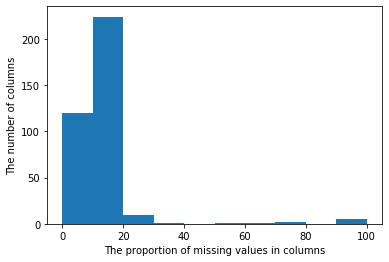

In [32]:
#The distribution of the proportion of missing values in each column
bin_edges = np.arange(0, azdias_col_null_prop.max()+10, 10)
plt.hist(azdias_col_null_prop, bins = bin_edges)

plt.xlabel("The proportion of missing values in columns")
plt.ylabel("The number of columns")

We can see that most columns only contain less than 20% of missing values. There is only very few columns having more than 50% of missing values.  
The columns that contain too many missing values should be removed. Here I set the threshold to be over 35%. 9 columns will be dropped.

In [33]:
cols_drop = azdias_col_null_prop[azdias_col_null_prop>35].index
cols_drop

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],
      dtype='object')

In [34]:
azdias.drop(cols_drop, axis=1, inplace=True)
azdias.shape

(891221, 355)

Then, we consider the missing values in each row.

In [35]:
# the proportion of missing values each row
azdias_row_null_prop = round(azdias.isnull().mean(axis=1)*100, 1).sort_values(ascending=False)
azdias_row_null_prop

LNR
340160    71.5
977363    71.5
422603    71.3
530837    71.3
593279    71.3
          ... 
263646     0.0
263654     0.0
263656     0.0
263659     0.0
500922     0.0
Length: 891221, dtype: float64

In [36]:
# the frequency of the proportion of missing values in rows
azdias_row_null_prop.value_counts().sort_index(ascending=False)

71.5         2
71.3         3
70.7        12
70.4         1
70.1     45578
69.9     27921
69.3         1
69.0         4
68.7         3
68.5         4
68.2        15
67.9         9
67.6         6
67.3        29
67.0        11
66.5         8
66.2       255
65.9        50
65.6        57
65.4        83
65.1      1045
64.8      1286
64.5       600
64.2      1229
63.9        95
63.7        89
63.4        61
63.1        94
62.8       204
62.5       767
62.3      1486
62.0      2608
61.7      7228
61.4      2148
61.1       171
60.6         3
60.3         5
60.0         1
59.7         4
59.4         5
59.2         6
58.9        17
58.6        12
58.3         7
58.0        42
57.7        48
57.5        30
57.2        73
56.9        36
56.6        69
56.3       142
56.1        56
55.8       145
55.5       193
55.2       115
54.9       149
54.6       362
54.4       265
54.1       710
53.8       431
53.5       348
53.2      1603
53.0       281
52.7       244
52.4      1063
52.1        14
51.8      

Text(0, 0.5, 'The number of rows')

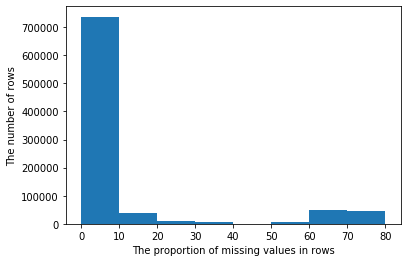

In [38]:
#The distribution of the proportion of missing values in each row
bin_edges = np.arange(0, azdias_row_null_prop.max()+10, 10)
plt.hist(azdias_row_null_prop, bins = bin_edges)

plt.xlabel("The proportion of missing values in rows")
plt.ylabel("The number of rows")

We can see that about most rows contain less than 10% of missing values in each row.

In [39]:
# the percent of rows contain 10% or less missing values
len(azdias_row_null_prop[azdias_row_null_prop < 10])/len(azdias_row_null_prop)*100

82.71809124784986

In [40]:
# the percent of rows contain 20% or less missing values
len(azdias_row_null_prop[azdias_row_null_prop < 20])/len(azdias_row_null_prop)*100

86.87171868705967

The rows contain 10% or less missing values represent 82.7% of the dataset. The rows contain 20% or less missing values represent 87.0% of the dataset.  
To make sure the rows contain enough information, I decide to drop the rows with 10% or more missing values.

In [41]:
azdias = azdias[azdias.isnull().mean(axis=1)*100 < 10].reset_index(drop = True)
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_REN

In [42]:
azdias.shape

(737201, 355)

#### Deal with categorical variables

To use unsupervised learning techniques, we need to create dummy variables for the categorical features. The categorical features are:   
ANREDE_KZ, CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, D19_KONSUMTYP, D19_LETZTER_KAUF_BRANCHE, FINANZTYP, GEBAEUDETYP, GFK_URLAUBERTYP, GREEN_AVANTGARDE, HEALTH_TYP, KK_KUNDENTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, OST_WEST_KZ, PRAEGENDE_JUGENDJAHRE, RETOURTYP_BK_S, SHOPPER_TYP, SOHO_KZ, VERS_TYP, WOHNLAGE, ZABEOTYP

For binary variables, there is no need to create dummy variables as long as they are numeric.

In [44]:
cat_columns = "ANREDE_KZ, CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, D19_KONSUMTYP, D19_LETZTER_KAUF_BRANCHE, FINANZTYP, GEBAEUDETYP, GFK_URLAUBERTYP, GREEN_AVANTGARDE, HEALTH_TYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, OST_WEST_KZ, PRAEGENDE_JUGENDJAHRE, RETOURTYP_BK_S, SHOPPER_TYP, SOHO_KZ, VERS_TYP, WOHNLAGE, ZABEOTYP"
cat_list = [i.strip(" ") for i in cat_columns.split(",")]
len(cat_list)

27

In [45]:
# separate categorical features into binary and multi-level variables
binary_list = []
multi_list = []

for feature in cat_list:
    if len(azdias[feature].value_counts()) == 2:
        binary_list.append(feature)
    else:
        multi_list.append(feature)
print("Binary variables are: ", binary_list)
print("Multi-level variables are: ", multi_list)

Binary variables are:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ', 'VERS_TYP']
Multi-level variables are:  ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'WOHNLAGE', 'ZABEOTYP']


In [46]:
azdias[binary_list].dtypes

ANREDE_KZ             int64
GREEN_AVANTGARDE      int64
OST_WEST_KZ          object
SOHO_KZ             float64
VERS_TYP            float64
dtype: object

In [47]:
azdias.OST_WEST_KZ.value_counts()

W    582211
O    154990
Name: OST_WEST_KZ, dtype: int64

OST_WEST_KZ needs to be re-encode to numeric values.

In [48]:
azdias["OST_WEST_KZ"] = azdias.OST_WEST_KZ.map({"W":0, "O":1})

In [49]:
azdias.OST_WEST_KZ.value_counts() # check if all re-encoded

0    582211
1    154990
Name: OST_WEST_KZ, dtype: int64

For multi-level variables, if we directly create dummy variables for all, there will be too many columns and higher probability of overfitting. Therefore, we need to analyze each of the columns to see whether to drop, to combine some levels, or create dummy variables for all the levels.

In [50]:
# get dummy variables for multi-level variables
azdias_cat = azdias[multi_list]
azdias_dummy = pd.get_dummies(azdias_cat, columns = multi_list, prefix = multi_list)
azdias_dummy.shape # 278 columns are too many

(737201, 278)

In [51]:
azdias[multi_list].nunique().sort_index() # look at the number of levels for each variables

CAMEO_DEUG_2015              9
CAMEO_DEU_2015              44
CAMEO_INTL_2015             21
CJT_GESAMTTYP                6
D19_KONSUMTYP                7
D19_LETZTER_KAUF_BRANCHE    35
FINANZTYP                    6
GEBAEUDETYP                  7
GFK_URLAUBERTYP             12
HEALTH_TYP                   3
LP_FAMILIE_FEIN             12
LP_FAMILIE_GROB              6
LP_LEBENSPHASE_FEIN         41
LP_LEBENSPHASE_GROB         13
LP_STATUS_FEIN              10
LP_STATUS_GROB               5
NATIONALITAET_KZ             3
PRAEGENDE_JUGENDJAHRE       15
RETOURTYP_BK_S               5
SHOPPER_TYP                  4
WOHNLAGE                     8
ZABEOTYP                     6
dtype: int64

CJT_GESAMTTYP represents customer journey typology. D19_KONSUMTYP represents consumption type. GFK_URLAUBERTYP represents vacation habits. HEALTH_TYP represents health typology. NATIONALITAET_KZ represents nationaltity (scored by prename analysis). RETOURTYP_BK_S represents return type. SHOPPER_TYP represents shopping typology. ZABEOTYP represents typification of energy consumers. These are all useful information for clustering and do not have too many levels. Therefore, I decide to include this variable and encode it into dummy variables.

CAMEO_DEUG_2015, CAMEO_DEU_2015 are both German CAMEO Typology with different classification methods. They are quite similar. I decide to keep CAMEO_DEUG_2015, the one that has less levels and encode it into dummy variables.  

CAMEO_INTL_2015 is also a German CAMEO Typology. The levels combine two kind of information: the first digit represents the household from poorer to wealthy. The second digit represents the family type from Pre-Family Couples & Singles to Elders In Retirement. This variable can be separated into two ordinary variables.

D19_LETZTER_KAUF_BRANCHE is the last product group that has transactional activity. Since the other "D19" already includes information about the transactional activity based on different product groups. This column can be dropped.

FINANZTYP describes the financial type for the person. This variable can be useful. But there are variables (FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER) representing how likely the person should belong to each financial type. These variables already contain the information in FINANZTYP. Therefore, I decide to drop this variable.

GEBAEUDETYP represents the type of building (residential or commercial). The levels include resident, company or mixed building with or without actually known household. Since the number of households known in this building is represented by ANZ_HAUSHALTE_AKTIV, we can reduce the levels of GEBAEUDETYP to only three and include only the information about the building itself. And then create dummy variables for this variable.

LP_FAMILIE_FEIN and LP_FAMILIE_GROB both represent lifestage. The former one is a fine version and the latter one is a rough version. I decide to only keep the rough version, that is LP_FAMILIE_GROB. Similarly, I decide to keep LP_STATUS_GROB. For LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, since LP_FAMILIE_GROB and LP_STATUS_GROB already contain the information, I decide to drop these two variables.

PRAEGENDE_JUGENDJAHRE represents dominating movement in the person's youth (avantgarde or mainstream). It combines three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). Therefore, this can be separated into three variables. Since nation is indicated in OST_WEST_KZ, only the first two variables should be kept.

Similary, WOHNLAGE can also be separated into two categorical variables, since it combines neighbourhood-area from very good to rather poor and whether it is rural or not.

In all the new variables created, there are some ordinal variables, such as the first variable from CAMEO_INTL_2015. These ordinal variables do not need to convert to dummy variables.

In [52]:
#look at the levels of CAMEO_INTL_2015
azdias.CAMEO_INTL_2015.value_counts().sort_index()

12.0     11921
13.0     24204
14.0     58469
15.0     16237
22.0     30252
23.0     19862
24.0     84599
25.0     37177
31.0     16134
32.0      9690
33.0      9050
34.0     17309
35.0      9694
41.0     86803
43.0     53999
44.0     13866
45.0     25019
51.0    126311
52.0     20052
54.0     42701
55.0     20514
Name: CAMEO_INTL_2015, dtype: int64

In [53]:
#separate it into two variables
azdias['CAMEO_INTL_2015_household'] = azdias.CAMEO_INTL_2015.apply(lambda x: int(str(x)[0]) if len(str(x)) == 4 else np.nan)
azdias.CAMEO_INTL_2015_household.value_counts() # ordinal variable

5.0    209578
4.0    179687
2.0    171890
1.0    110831
3.0     61877
Name: CAMEO_INTL_2015_household, dtype: int64

In [54]:
azdias['CAMEO_INTL_2015_family'] = azdias.CAMEO_INTL_2015.apply(lambda x: int(str(x)[1]) if len(str(x)) == 4 else np.nan)
azdias.CAMEO_INTL_2015_family.value_counts() # ordinal variable

1.0    229248
4.0    216944
5.0    108641
3.0    107115
2.0     71915
Name: CAMEO_INTL_2015_family, dtype: int64

In [55]:
# look at the levels of GEBAEUDETYP
azdias.GEBAEUDETYP.value_counts().sort_index()

1.0    422178
2.0      4261
3.0    163082
4.0       830
5.0         1
6.0       559
8.0    146290
Name: GEBAEUDETYP, dtype: int64

**The numbers represent:**  
1	- residental building  
2	- residental building buildings without actually known household  
3	- mixed (=residential and company) building   
4	- mixed building without actually known household or company   
5	- company building w/o known company   
6	- mixed building without actually known household   
7	- company building  
8	- mixed building without actually known company  

In [56]:
# re-encode the variable to only include three types
# 0 for residental building, 1 for mixed building or company building (since there is only one)
azdias.GEBAEUDETYP = azdias.GEBAEUDETYP.map({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 8:1})
azdias.GEBAEUDETYP.value_counts().sort_index() # since it becomes a binary variable, no need to create dummy variables

0    426439
1    310762
Name: GEBAEUDETYP, dtype: int64

In [57]:
# look at the levels of PRAEGENDE_JUGENDJAHRE
azdias.PRAEGENDE_JUGENDJAHRE.value_counts().sort_index()

1.0      18632
2.0       7376
3.0      51156
4.0      20103
5.0      80973
6.0      25165
7.0       3844
8.0     130746
9.0      32178
10.0     78626
11.0     32383
12.0     22469
13.0      5062
14.0    168614
15.0     38726
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

**The numbers represent:**  
1	- 40ies - war years (Mainstream, O+W)  
2	- 40ies - reconstruction years (Avantgarde, O+W)  
3	- 50ies - economic miracle (Mainstream, O+W)  
4	- 50ies - milk bar / Individualisation (Avantgarde, O+W)  
5	- 60ies - economic miracle (Mainstream, O+W)   
6	- 60ies - generation 68 / student protestors (Avantgarde, W)  
7	- 60ies - opponents to the building of the Wall (Avantgarde, O)  
8	- 70ies - family orientation (Mainstream, O+W)  
9	- 70ies - peace movement (Avantgarde, O+W)  
10	- 80ies - Generation Golf (Mainstream, W)  
11	- 80ies - ecological awareness (Avantgarde, W)  
12	- 80ies - FDJ / communist party youth organisation (Mainstream, O)  
13	- 80ies - Swords into ploughshares (Avantgarde, O)  
14	- 90ies - digital media kids (Mainstream, O+W)  
15	- 90ies - ecological awareness (Avantgarde, O+W)  

In [58]:
# separate into two variables
# 1-6 for 40ies to 90ies
azdias["PRAEGENDE_JUGENDJAHRE_decade"] = azdias.PRAEGENDE_JUGENDJAHRE.map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6})
azdias.PRAEGENDE_JUGENDJAHRE_decade.value_counts().sort_index() # ordinal data

1.0     26008
2.0     71259
3.0    109982
4.0    162924
5.0    138540
6.0    207340
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64

In [59]:
# 0 for Mainstream, 1 for Avantgarde
azdias["PRAEGENDE_JUGENDJAHRE_movement"] = azdias.PRAEGENDE_JUGENDJAHRE.map({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1})
azdias.PRAEGENDE_JUGENDJAHRE_movement.value_counts().sort_index() # binary variable, no need to create dummy variables

0.0    551216
1.0    164837
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64

In [60]:
# look at the levels of WOHNLAGE
azdias.WOHNLAGE.value_counts().sort_index()

0.0        17
1.0     41432
2.0     94531
3.0    235379
4.0    127383
5.0     67915
7.0    161347
8.0      9197
Name: WOHNLAGE, dtype: int64

**The numbers represent:**  
0	- no score calculated  
1	- very good neighbourhood  
2	- good neighbourhood  
3	- average neighbourhood  
4	- poor neighbourhood  
5	- very poor neighbourhood  
7	- rural neighbourhood  
8	- new building in rural neighbourhood  

In [61]:
# separate into two variables
# 0 for non-rural neighbourhood, 1 for rural neighbourhood, "no score calculated" should be treated as missing vlaue
azdias["WOHNLAGE_rural"] = azdias.WOHNLAGE.map({0:np.nan,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
azdias.WOHNLAGE_rural.value_counts().sort_index() # binary variable, no need to create dummy variables

0.0    566640
1.0    170544
Name: WOHNLAGE_rural, dtype: int64

In [62]:
# 1-5 from very good to very poor area, 0 for others
azdias["WOHNLAGE_neighbour"] = azdias.WOHNLAGE.map({0:np.nan,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
azdias.WOHNLAGE_neighbour.value_counts().sort_index() # ordinal data

0.0    170544
1.0     41432
2.0     94531
3.0    235379
4.0    127383
5.0     67915
Name: WOHNLAGE_neighbour, dtype: int64

In [63]:
# drop unused columns
azdias.drop(["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE", "FINANZTYP", "LP_FAMILIE_FEIN", "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "PRAEGENDE_JUGENDJAHRE", "WOHNLAGE"], axis = 1, inplace = True)
azdias.shape

(737201, 351)

In [64]:
# get dummy variables for keeped multi-level variables
keep_list = ['CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']
azdias_cat = azdias[keep_list]
azdias_dummy = pd.get_dummies(azdias_cat, columns = keep_list, prefix = keep_list)
azdias_dummy.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,HEALTH_TYP_1.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,RETOURTYP_BK_S_1.0,RETOURTYP_BK_S_2.0,RETOURTYP_BK_S_3.0,RETOURTYP_BK_S_4.0,RETOURTYP_BK_S_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [65]:
azdias_dummy.shape

(737201, 66)

In [66]:
# combine with the dataset and drop these original categorical variables
azdias = pd.concat([azdias.drop(keep_list, axis=1), azdias_dummy], axis = 1)
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

In [67]:
azdias.shape #737201 rows and 406 columns

(737201, 406)

#### Create a clean function
In order to apply the preprocessing steps on all datasets, it would be better to create a clean function.

In [8]:
def clean_dataset(df):
    """
    Preprocess the data by dealing with missing values and categorical variables

    INPUT:
    df: DataFrame, the original dataset
    
    OUTPUT:
    cleaned_df: DataFrame, the cleaned dataset
    """

    print("The shape of the original dataset: ", df.shape)
    
    # set LNR to be the index
    df.set_index("LNR", inplace=True)
    
    # Deals with missing values

    # convert all the missing values to np.nan
    # load in the descriptions of each column to see which columns contain "unknown" value
    attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1, usecols = "B:E")
    attributes.ffill(inplace=True)
    unknown_values = attributes.loc[attributes.Meaning.str.contains("unknown")]

    # convert all the "unknown" into np.nan
    for index, row in unknown_values.iterrows():
        attribute = row["Attribute"]
        values = row["Value"]

        value_list = []
        if type(values) != int:
            value_list = values.split(",")
        else:
            value_list.append(values)

        for i in value_list:
            df[attribute] = df[attribute].replace(int(i), np.nan)

    # convert missing values in object data to np.nan
    df["CAMEO_DEU_2015"] = df["CAMEO_DEU_2015"].replace("XX", np.nan)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].replace("X", np.nan)
    df["CAMEO_INTL_2015"] = df.CAMEO_INTL_2015.replace("XX", np.nan)

    # ensure the object data is in the right data type
    df.CAMEO_DEUG_2015 = df.CAMEO_DEUG_2015.apply(lambda x: float(x))
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.apply(lambda x: float(x))

    # drop unuseful column with object data
    df.drop("EINGEFUEGT_AM", axis=1, inplace=True)

    # deals with missing values in columns
    df_col_null_prop = round(df.isnull().mean()*100,1).sort_values(ascending=False)
    cols_drop = df_col_null_prop[df_col_null_prop > 40].index
    df.drop(cols_drop, axis=1, inplace=True) # drop columns that have 50% or more missing values

    # deals with missing values in rows
    df_row_null_prop = round(df.isnull().mean(axis=1)*100, 1).sort_values(ascending=False)
    df = df[df.isnull().mean(axis=1)*100 < 10].reset_index(drop = True)
    # drop rows that have 10% or more missing values

    print("The shape of the dataset after handling NaNs: ", df.shape)


    # Deal with categorical variables

    # separate categorical features into binary and multi-level variables
    cat_columns = '''ANREDE_KZ, CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, D19_KONSUMTYP, \
                    D19_LETZTER_KAUF_BRANCHE, FINANZTYP, GEBAEUDETYP, GFK_URLAUBERTYP, GREEN_AVANTGARDE, HEALTH_TYP, \
                    LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, \
                    LP_STATUS_GROB, NATIONALITAET_KZ, OST_WEST_KZ, PRAEGENDE_JUGENDJAHRE, RETOURTYP_BK_S, SHOPPER_TYP, \
                    SOHO_KZ, VERS_TYP, WOHNLAGE, ZABEOTYP'''
    cat_list = [i.strip(" ") for i in cat_columns.split(",")]

    binary_list = []
    multi_list = []

    for feature in cat_list:
        if len(df[feature].value_counts()) == 2:
            binary_list.append(feature)
        else:
            multi_list.append(feature)

    #re-encode binary variable OST_WEST_KZ
    df["OST_WEST_KZ"] = df.OST_WEST_KZ.map({"W":0, "O":1})

    #separate CAMEO_INTL_2015_household into two variables
    df['CAMEO_INTL_2015_household'] = df.CAMEO_INTL_2015.apply(lambda x: int(str(x)[0]) if len(str(x)) == 4 else np.nan)
    df['CAMEO_INTL_2015_family'] = df.CAMEO_INTL_2015.apply(lambda x: int(str(x)[1]) if len(str(x)) == 4 else np.nan)

    # re-encode GEBAEUDETYP to only include three types
    # 0 for residental building, 1 for mixed building or company building (since there is only one)
    df.GEBAEUDETYP = df.GEBAEUDETYP.map({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 8:1})

    # separate PRAEGENDE_JUGENDJAHRE into two variables
    # 1-6 for 40ies to 90ies
    df["PRAEGENDE_JUGENDJAHRE_decade"] = df.PRAEGENDE_JUGENDJAHRE.map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, \
                                                                       10:5, 11:5, 12:5, 13:5, 14:6, 15:6})
    # 0 for Mainstream, 1 for Avantgarde
    df["PRAEGENDE_JUGENDJAHRE_movement"] = df.PRAEGENDE_JUGENDJAHRE.map({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, \
                                                                         10:0, 11:1, 12:0, 13:1, 14:0, 15:1})

    # separate WOHNLAGE into two variables
    # 0 for non-rural neighbourhood, 1 for rural neighbourhood, "no score calculated" should be treated as missing vlaue
    df["WOHNLAGE_rural"] = df.WOHNLAGE.map({0:np.nan,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    # 1-5 from very good to very poor area, 0 for others
    df["WOHNLAGE_neighbour"] = df.WOHNLAGE.map({0:np.nan,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

    # drop unused columns
    df.drop(["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE", "FINANZTYP", "LP_FAMILIE_FEIN", \
             "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "PRAEGENDE_JUGENDJAHRE", "WOHNLAGE"], 
            axis = 1, inplace = True)

    # get dummy variables for keeped multi-level variables
    keep_list = ['CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', \
                 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']
    df_cat = df[keep_list]
    df_dummy = pd.get_dummies(df_cat, columns = keep_list, prefix = keep_list)

    # combine with the dataset and drop these original categorical variables
    df = pd.concat([df.drop(keep_list, axis=1), df_dummy], axis = 1)

    print("The shape of the dataset after handling categorical variables: ", df.shape)

    return df

In [7]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
azdias_cleaned = clean_dataset(azdias)
azdias_cleaned.to_csv("azdias_cleaned.csv", index=False) # keep a cleared version for future use

The shape of the original dataset:  (891221, 366)
The shape of the dataset after handling NaNs:  (737201, 355)
The shape of the dataset after handling categorical variables:  (737201, 406)


In [8]:
# apply to customer
customer = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
customer_cleaned = clean_dataset(customer).drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

The shape of the original dataset:  (191652, 369)
The shape of the dataset after handling NaNs:  (134242, 358)
The shape of the dataset after handling categorical variables:  (134242, 409)


In [9]:
customer_cleaned.shape

(134242, 406)

In [10]:
customer_cleaned.to_csv("customer_cleaned.csv", index=False) # keep a cleared version for future use

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Use PCA to reduce dimensions
Currently, the zadias dataset has 407 columns. This is too many for cluster analysis. Besides, some columns contain similar information about the customers and are highly correlated. Therefore, we need to reduce the dimension using PCA.  

In order to apply PCA, we need to first impute the missing values and standardized the data.

In [3]:
# load the cleaned version
azdias_cleaned = pd.read_csv('azdias_cleaned.csv')
azdias_cleaned.shape

(737201, 406)

In [5]:
azdias_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

#### Impute missing values with mode

In [6]:
azdias_cleaned.isnull().mean().mean() # the proportion of missing values in the cleaned dataset

0.006348523579097812

In [7]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mode.fit(azdias_cleaned)

azdias_imputed = pd.DataFrame(data = imp_mode.transform(azdias_cleaned), columns = azdias_cleaned.columns)
azdias_imputed.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

In [8]:
azdias_imputed.shape

(737201, 406)

In [9]:
azdias_imputed.isnull().mean().mean() # check if the dataset still contains missing values

0.0

#### Standardize the data

In [10]:
scaler = StandardScaler()
scaler.fit(azdias_imputed)
azdias_scaled = pd.DataFrame(data = scaler.transform(azdias_imputed), columns = azdias_cleaned.columns)
azdias_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

In [11]:
azdias_scaled.shape

(737201, 406)

#### Apply PCA

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

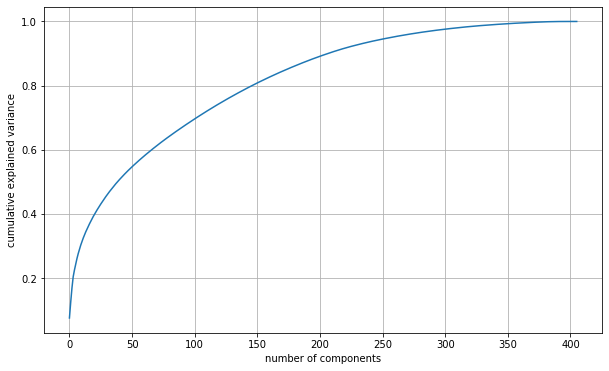

In [13]:
# proportion of variance explained by number of components
plt.figure(figsize = (10, 6)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the above plot, we can see that the first 100 components contain approximately 70% of the variance. The first 150 components contain more than 80% of the variance. We need around 200 components to describe close to 90% of the variance.

I decide to keep the first 100 components and maintained 70% of the information in the dataset.

In [14]:
sum(pca.explained_variance_ratio_[:100])

0.6937170340560067

#### Interpret the components

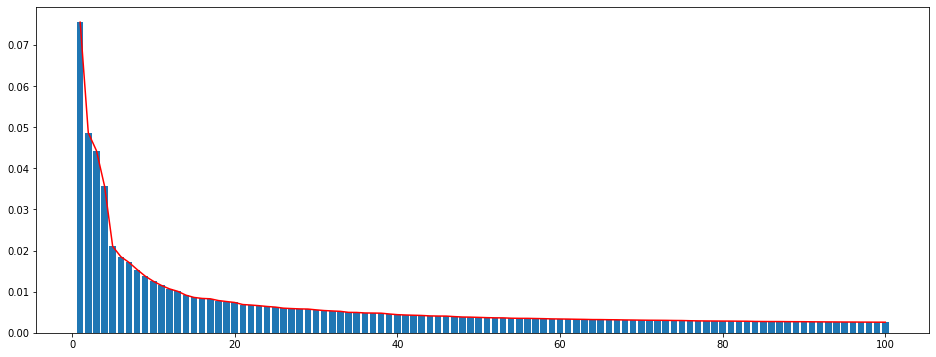

In [15]:
# the proportion of variance explained by each of the first 100 components
plt.figure(figsize = (16, 6))

plt.bar(list(range(1, len(pca.explained_variance_ratio_[:100])+1)), pca.explained_variance_ratio_[:100])
plt.plot(list(range(1, len(pca.explained_variance_ratio_[:100])+1)), \
         pca.explained_variance_ratio_[:100], color="red")

From the above plot, we can clearly see an "elbow" at 5th component. At this point, the proportion of variance explained by each subsequent principal component drops off. Therefore, the first 4 component can be seen as the most important principal components. Let's look at them in detail to find important features in the dataset.

In [17]:
# The importance of each feature in each component
pca_df = pd.DataFrame(pca.components_, columns = azdias_scaled.columns)
pca_df.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

In [18]:
def find_important_features(i):
    """
    Find the most important 8 features and the corresponding values in the eigenvectors of the ith component
    
    Input:
    i: The index of the ith component
    
    Output:
    important_features: Dataframe. The most important 8 features and the corresponding values
    """

    important_features = pd.concat([pca_df.loc[i,:].sort_values(ascending=False).head(4), 
                                    pca_df.loc[i,:].sort_values(ascending=False).tail(4)])
    return important_features

##### 1st component

In [19]:
find_important_features(0)

MOBI_REGIO      0.136566
PLZ8_ANTG1      0.130167
KBA13_ANTG1     0.129569
KBA05_ANTG1     0.126291
KBA13_BAUMAX   -0.124097
KBA13_ANTG4    -0.124955
KBA13_ANTG3    -0.128571
PLZ8_ANTG3     -0.129226
Name: 0, dtype: float64

MOBI_REGIO means moving patterns. PLZ8_ANTG1 and PLZ8_ANTG3 represent the proportion of 1-2 and 6-10 family houses in the PLZ8. KBA05_ANTG1 means number of 1-2 family houses in the cell.  

KBA13_ANTG1, KBA13_ANTG4, KBA13_BAUMAX are missing from the description file. But based on their names, these variables should also about PLZ8 regions and are likely to be information about the family houses or cars in this region.  

Therefore, we can summarize this component as measuring the living area of individuals.

##### 2nd component

In [20]:
find_important_features(1)

ONLINE_AFFINITAET               0.154587
PRAEGENDE_JUGENDJAHRE_decade    0.153072
CJT_TYP_2                       0.148287
FINANZ_SPARER                   0.146557
CJT_TYP_6                      -0.133543
CJT_TYP_4                      -0.138809
FINANZ_VORSORGER               -0.139565
CJT_TYP_5                      -0.141274
Name: 1, dtype: float64

ONLINE_AFFINITAET means online affinity. PRAEGENDE_JUGENDJAHRE_decade represents the decade of the individual.
CJT_TYP_2, CJT_TYP_6, CJT_TYP_4, CJT_TYP_5 are all about Customer-Journey-Typology.
FINANZ_SPARER and FINANZ_VORSORGER are financial typology. While the former one measures whether the individual is a money saver, the latter one measures whether he or she is prepared.

Therefore, this component measures customer behaviors and characteristics.

##### 3rd component

In [21]:
find_important_features(2)

KBA13_HERST_BMW_BENZ           0.181433
KBA13_SEG_OBEREMITTELKLASSE    0.156328
KBA13_MERCEDES                 0.155023
KBA13_BMW                      0.151525
KBA13_HALTER_25               -0.118343
KBA13_KMH_140_210             -0.128080
KBA13_SEG_KLEINWAGEN          -0.129303
KBA13_SITZE_5                 -0.149023
Name: 2, dtype: float64

KBA13_HERST_BMW_BENZ means share of BMW & Mercedes Benz within the PLZ8. KBA13_SEG_OBEREMITTELKLASSE means share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.). KBA13_MERCEDES means share of MERCEDES within the PLZ8. KBA13_BMW means share of BMW within the PLZ8. KBA13_HALTER_25 means share of car owners between 21 and 25 within the PLZ8. KBA13_KMH_140_210 means share of cars with max speed between 140 and 210 km/h within the PLZ8. KBA13_SEG_KLEINWAGEN means share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8. KBA13_SITZE_5 means number of cars with 5 seats in the PLZ8.  

These variables are all about the cars in the PLZ8 area. The brand and type of the cars can represent the social status of the individuals living in this area.

##### 4th component

In [22]:
find_important_features(3)

FINANZ_VORSORGER                0.119651
ALTERSKATEGORIE_GROB            0.115301
CJT_TYP_5                       0.109182
D19_GESAMT_ANZ_24               0.108734
FINANZ_UNAUFFAELLIGER          -0.129866
VK_ZG11                        -0.129968
FINANZ_SPARER                  -0.130348
PRAEGENDE_JUGENDJAHRE_decade   -0.131510
Name: 3, dtype: float64

FINANZ_VORSORGER, FINANZ_UNAUFFAELLIGER, and FINANZ_SPARER are all financial typology. FINANZ_VORSORGER measures whether the individual is prepared, FINANZ_UNAUFFAELLIGER means unremarkable, and FINANZ_SPARER measures money saver.
ALTERSKATEGORIE_GROB means age classification through prename analysis. This is similar to PRAEGENDE_JUGENDJAHRE_decade.
D19_GESAMT_ANZ_24 is transaction activity TOTAL POOL in the last 24 months.

VK_ZG11 is missing from the description file. Based on my search result, VK may be short for sales department or sales price. TG is short for call money. 

Therefore, this component is also about customer behaviors and characteristics.

**The most important features can be summarized in 5 types:**  

- About **family houses** in the living area: MOBI_REGIO, PLZ8_ANTG1, PLZ8_ANTG3, KBA05_ANTG1, KBA13_ANTG1, KBA13_ANTG4
- About **cars** in the living area: KBA13_BAUMAX, KBA13_HERST_BMW_BENZ, KBA13_SEG_OBEREMITTELKLASSE, KBA13_MERCEDES, KBA13_BMW, KBA13_HALTER_25, KBA13_KMH_140_210, KBA13_SEG_KLEINWAGEN, KBA13_SITZE_5
- **Customer behaviors**: CJT_TYP_2, CJT_TYP_6, CJT_TYP_4, CJT_TYP_5, D19_GESAMT_ANZ_24, VK_ZG11, ONLINE_AFFINITAET
- **Financial typology**: FINANZ_VORSORGER, FINANZ_UNAUFFAELLIGER, and FINANZ_SPARER
- **Decade** of the individual: PRAEGENDE_JUGENDJAHRE_decade, ALTERSKATEGORIE_GROB

#### Write a function to apply PCA

In [24]:
def reduce_dimension(df_fit, df_transform=None, n=100):
    """
    Impute missing values in dataset, standardize the data and apply PCA on the dataset to reduce dimensions
    
    Input:
    df_fit: the dataset to fit the model
    df_transform: the dataset to apply the dimensionality reduction, if None, then it's the same as df_fit
    n: the number of dimensions remained
    
    Output:
    df_pca: the transformed dataset
    """
    
    # impute the missing values
    imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    imp_mode.fit(df_fit)
    df_imputed = pd.DataFrame(data = imp_mode.transform(df_fit), columns = df_fit.columns)

    # standardize the data
    scaler = StandardScaler()
    scaler.fit(df_imputed)
    df_scaled = pd.DataFrame(data = scaler.transform(df_imputed), columns = df_imputed.columns)

    # apply PCA
    pca = PCA(n)
    pca.fit(df_scaled)
    
    if type(df_transform) != type(None):
        df_transform_imputed = pd.DataFrame(data = imp_mode.transform(df_transform), columns = df_transform.columns)
        df_transform_scaled = pd.DataFrame(data = scaler.transform(df_transform_imputed), columns = df_transform.columns)
        df_pca = pd.DataFrame(data = pca.transform(df_transform_scaled))
        print("Shape after imputing NaNs: ", df_transform_imputed.shape)
        print("Shape after standardizing: ", df_transform_scaled.shape)
    else:
        df_pca = pd.DataFrame(data = pca.transform(df_scaled))
        print("Shape after imputing NaNs: ", df_imputed.shape)
        print("Shape after standardizing: ", df_scaled.shape)
    
    print("Shape after applying PCA: ", df_pca.shape)
        
    return df_pca        

In [25]:
azdias_cleaned = pd.read_csv('azdias_cleaned.csv')
azdias_pca = reduce_dimension(azdias_cleaned, n=100)

Shape after imputing NaNs:  (737201, 406)
Shape after standardizing:  (737201, 406)
Shape after applying PCA:  (737201, 100)


In [26]:
azdias_pca.to_csv("azdias_pca.csv", index=False) # keep for future use

In [28]:
customer_cleaned = pd.read_csv('customer_cleaned.csv')
customer_cleaned.shape

(134242, 406)

In [31]:
#apply to customer data
customer_cleaned_pca = reduce_dimension(azdias_cleaned, customer_cleaned, n=100)
customer_cleaned_pca.to_csv("customer_pca.csv", index=False) # keep for future use

Shape after imputing NaNs:  (134242, 406)
Shape after standardizing:  (134242, 406)
Shape after applying PCA:  (134242, 100)


### Cluster Analysis
We use k-means clustering to segment the general population and customers.

#### Decide the optimal number of clusters k

In [32]:
kmeans_kwargs = {"init":"random", "n_init":10, "max_iter":300, "random_state":42}

sse = []
k_list = range(2,20) # potential number of clusters
for k in k_list:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(azdias_pca)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

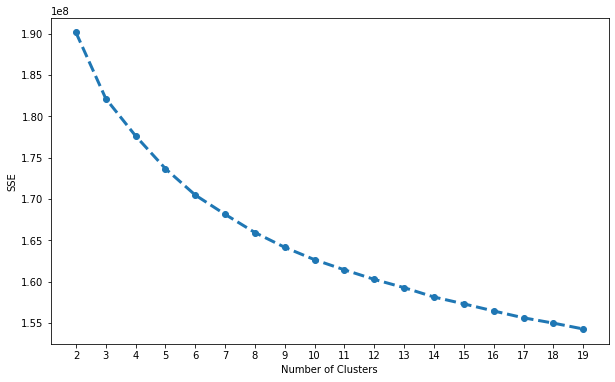

In [33]:
fig = plt.figure(figsize = (10, 6))
plt.plot(k_list, sse, linestyle = "--", linewidth = 3, marker='o')
plt.xticks(k_list)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

From the plot, I decide to keep 6 clusters.

In [34]:
kmeans_kwargs = {"init":"random", "n_init":10, "max_iter":300, "random_state":42}
kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
kmeans.fit(azdias_pca)

KMeans(init='random', n_clusters=6, random_state=42)

In [35]:
azdias_pca["cluster_label"] = kmeans.labels_
azdias_pca.cluster_label.value_counts().sort_index()

0    130624
1    130553
2    138413
3    116612
4    129523
5     91476
Name: cluster_label, dtype: int64

#### Apply clustering to customer dataset and compare the results

In [37]:
customer_cleaned_pca['cluster_label'] = kmeans.predict(customer_cleaned_pca)
customer_cleaned_pca.cluster_label.value_counts().sort_index()

0     3102
1     1598
2    35449
3    15808
4    43395
5    34890
Name: cluster_label, dtype: int64

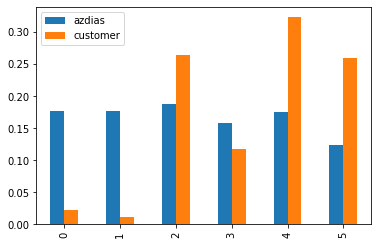

In [38]:
# The distribution of clusters in general population vs customers
prop_azdias = azdias_pca.cluster_label.value_counts().sort_index()/azdias_pca.shape[0]
prop_customer = customer_cleaned_pca.cluster_label.value_counts().sort_index()/customer_cleaned_pca.shape[0]

pd.DataFrame(data = {"azdias":list(prop_azdias), "customer":list(prop_customer)}).plot.bar()

From the above plot, we can see that cluster 0, 1, and 3 are highly likely to be the customers. Cluster 5 are less likely than the previous 3 clusters. Cluster 2 and 4 are much unlikely to be the customers.

In [39]:
# keep a clustered version for future use
azdias_pca.to_csv("azdias_clustered.csv", index=False)
customer_cleaned_pca.to_csv("customer_clustered.csv", index=False)

#### Interpret the clusters

In [5]:
azdias_clustered = pd.read_csv("azdias_clustered.csv")
azdias_clustered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_label
0,-5.045095,2.166359,6.051300,-6.046598,0.258858,-2.182192,3.994520,1.096087,-0.551740,-2.083920,2.106468,-2.254560,2.387274,-0.237702,-1.179766,-2.314424,1.781032,-1.125869,-2.492405,0.865118,0.437732,-0.534554,0.203638,-0.135867,-1.933698,-0.162679,-2.264049,1.088746,0.657242,3.855833,1.829239,1.687990,1.427257,2.298036,0.880954,1.566743,2.198150,-0.772259,1.013325,-0.080486,-0.155534,0.489187,-1.476026,0.313744,-0.905512,-1.071164,0.511535,-0.841539,-0.182964,0.407169,-0.788213,0.738840,1.578895,0.083361,0.725441,-0.913222,4.621618,-0.266651,-0.436112,-2.090188,-0.575341,-1.200694,-1.113955,-1.485637,2.475570,-1.000067,-1.059672,1.673461,-2.048317,2.376229,0.489019,-1.476249,-0.525605,-1.141167,-1.738522,1.715044,-0.558137,-0.070900,0.305170,1.641520,-1.058256,-0.687749,1.797068,-2.318975,-0.225423,2.421896,0.368221,0.153497,1.194988,-1.138263,0.140109,0.149054,1.148011,0.387554,2.348548,-2.102205,1.723177,-2.101957,-0.407954,2.202296,1
1,0.589196,-1.755054,2.309187,-3.445122,4.305319,-4.091121,-4.674375,-2.177512,1.559029,1.339020,-1.645781,-1.248778,-1.824188,0.951211,0.019346,-0.266606,1.910115,1.294586,0.070119,-2.975858,-0.080090,-0.780862,-1.090049,0.989118,-0.781786,-2.002577,-0.755281,-0.095970,-1.360178,0.328339,-0.637569,0.149886,-0.074148,0.805320,0.278344,-2.822249,1.444972,-2.513748,1.221382,1.569644,0.302904,-0.081077,-0.197921,-0.199251,-0.214709,0.513945,1.077800,0.393430,-0.047006,1.171980,-0.328872,-0.785979,-1.495878,-1.180379,-0.385408,0.404099,-0.581995,2.190212,0.922463,0.146682,-0.363586,0.985227,1.906946,-0.876585,-0.196127,0.358475,-1.190386,0.340742,-0.114750,1.262812,1.340683,0.185462,0.175223,0.932968,-0.645531,-0.346233,-2.282842,0.455349,-0.222062,-0.915587,0.915595,-0.006809,-1.044511,0.238692,0.251292,-1.645854,0.586563,0.809897,-0.549382,0.266322,-0.012296,-0.002018,-1.049261,-0.979572,-1.000620,0.040761,-0.081654,0.095232,0.754618,1.280814,1
2,4.554100,-6.049407,-0.866915,-3.011390,-1.184392,-1.682492,1.951297,-1.466533,-2.789791,-2.015941,0.125714,-0.416032,0.077318,-0.268469,0.863977,2.824430,0.311611,1.633986,1.066399,0.632030,-0.334141,0.056654,0.306000,-1.277956,1.858371,-1.448639,0.054763,-0.494266,-1.880080,-0.248756,-0.841546,-0.935030,0.662169,0.025859,-1.419119,-1.191760,2.369976,5.704664,1.361280,-0.080754,-2.848161,1.042805,-0.971814,0.226904,-0.546874,-0.242735,0.487493,-1.144446,0.741282,0.931517,-0.090757,-1.784613,-1.044682,0.368782,-1.207269,0.965396,0.928536,0.420431,-0.399317,1.517774,0.605502,-0.629437,0.677724,0.940468,-1.322843,0.865755,1.906901,-0.568511,-0.053760,0.373136,-0.468944,1.531616,-0.601388,1.197990,0.746400,-1.449964,2.689401,1.294795,-0.127240,2.613894,1.529320,0.734025,1.976380,-0.980903,0.218540,-0.062178,2.381580,0.009352,-1.040940,-0.810495,1.316665,-1.091684,-1.483798,-0.559338,1.076161,0.505083,0.724793,-0.039981,1.085266,0.342690,4
3,5.318474,8.175047,3.618335,7.014865,-3.015067,2.928013,-1.841308,-3.841790,0.438595,-4.271148,0.542945,6.470747,-3.744944,-1.946673,-2.637531,3.638146,-0.741363,-1.247538,-2.354274,-0.624093,-1.129517,1.437805,2.820586,-2.663483,1.100671,-0.359407,1.858594,0.954066,-0.745742,0.180392,-1.190381,1.418815,-1.041719,-0.252017,-1.659824,-0.161750,-1.320124,-3.847768,1.507410,1.407702,-1.026247,-1.772656,-1.134334,-0.404938,1.374486,0.158520,1.244003,0.852486,-2.304994,0.152816,1.747726,0.972500,-0.857664,-0.815094,2.155263,1.510315,1.019562,0.202085,0.196575,0.427695,0.528476,0.151094,0.170454,0.821437,-0.890234,-0.941108,0.378327,-0.792597,-0.048182,-0.956690,2.062706,2.095095,0.528419,0.909664,1.166217,-0.845234,0.493580,0.871526,2.591832,0.283630,1.979349,0.285799,-0.373946,0.487642,2.283935,-0.664674,0.989422,0.642217,1.

In [6]:
customer_clustered = pd.read_csv("customer_clustered.csv")
customer_clustered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_label
0,7.979601,-8.230211,2.629630,0.398875,-1.132613,3.721947,-0.745417,0.022873,0.182857,-1.376879,-0.797088,-1.936703,1.990620,0.200193,0.141160,-1.732637,1.497701,-2.528396,1.319677,-0.546327,1.056236,-1.079988,0.447877,0.104140,-0.465542,0.292830,1.098653,-1.433234,1.364005,0.811576,-1.558392,1.237269,2.863183,0.158818,-1.330946,1.142997,-0.846763,-0.218672,-1.126923,-0.438511,-0.776609,0.595239,-2.244929,-0.167686,1.421502,0.895996,1.717177,0.127682,-0.745961,0.536423,0.274168,0.175742,0.671826,1.712842,-1.234753,-0.272319,0.433701,-1.860034,-0.520913,0.500296,-0.993985,0.739817,0.926040,0.295865,1.474490,1.099448,1.759354,3.365118,0.930388,-0.981587,0.616321,-0.407054,-1.601121,-0.345285,-0.530224,0.888187,-0.340427,0.824366,2.086735,-0.029051,1.619950,0.175961,0.294162,0.550976,-0.078864,1.376950,2.866921,-0.509757,0.073357,-0.127265,0.881873,0.674238,-0.213045,0.160833,-0.457798,-1.945354,1.557171,-0.293077,-0.560895,-0.887758,4
1,-1.281592,-8.036182,2.252304,4.215064,-3.533616,-0.658339,-1.576605,1.923494,-6.876974,-1.062571,1.665225,0.276025,0.283777,0.641891,-0.846110,2.178596,-0.958013,-1.075557,-0.889202,0.625563,-1.489470,-0.479085,-0.393059,0.099814,-0.246164,1.125019,-0.518332,0.184991,-1.837774,-0.072405,-0.158463,-0.351136,0.622275,-1.238062,-0.649082,1.685280,0.367639,0.535245,-0.515288,-0.582507,-0.356271,0.995205,0.233526,1.778716,-3.057685,-1.085686,1.935251,0.548912,-0.474294,-0.122664,-0.999248,0.515345,-2.124243,0.572665,0.585371,-0.637155,-0.200659,-1.446806,1.803757,0.038019,0.522667,0.716317,-1.495620,-0.867254,-0.306974,-0.680159,-1.329964,-1.369317,0.856857,0.289726,-0.326154,-0.019359,-0.548879,0.601784,-0.071230,1.116931,-1.166316,1.294945,-0.431799,0.693549,0.971214,0.548984,-1.534698,1.303908,1.033905,-0.147022,-0.315300,1.572637,-1.971982,-0.375885,-0.051811,1.001449,1.472325,2.463234,-1.365178,2.691758,-0.909143,-0.423229,1.175150,-0.954338,5
2,5.733136,-5.929488,-2.894354,0.455791,3.162048,3.185351,1.997942,-4.361002,0.384279,-0.095305,-2.177614,0.260449,-0.374790,3.236602,1.777465,-0.529133,0.309181,0.358897,1.399939,-0.419830,-0.832644,-0.798914,-0.643592,1.677960,-0.621278,1.663993,-0.980159,-0.212969,-0.835518,-3.834010,-0.289571,-3.064735,-1.093571,0.937563,-1.610478,-0.556537,2.799378,1.498700,0.121955,-0.523275,-0.581144,0.198234,-0.741552,0.626344,-0.971447,-2.370265,1.868645,-0.986246,2.097492,-2.287965,-0.160796,1.091924,2.768358,-1.043319,-0.095180,-1.089421,0.375602,0.069139,0.556210,1.192540,1.302973,0.042419,0.720211,-0.669164,0.441546,1.504233,2.035915,0.559353,1.052464,0.924816,-1.229640,-2.927290,2.466497,2.201613,-2.569863,-0.898994,0.634102,0.754933,-0.610087,1.373627,0.541174,-0.943557,-0.219224,-0.842583,0.272484,-0.526236,0.960451,-0.710196,0.073279,-0.727564,-0.707420,0.030378,0.551463,0.745285,-1.275547,1.115753,-0.253228,-1.075925,0.070053,0.570677,4
3,2.189186,7.778084,-0.327230,4.841136,-4.919401,1.544388,-0.767062,-0.140619,2.232192,-2.490250,1.340377,-0.224663,1.695328,-0.316517,0.827700,1.097293,0.692511,3.813055,-1.227345,1.649629,-1.751378,-2.335201,-1.015911,1.920944,0.617394,-1.198301,-2.308600,1.763722,1.364696,2.134992,-2.603942,-1.884127,-1.125560,-0.968369,-0.268226,0.590734,-2.454819,1.107246,0.398717,-0.700120,-1.759974,0.626828,2.273886,1.284081,0.064506,2.116392,-0.454635,-0.820603,-0.889092,1.115810,0.807536,0.824646,-0.320303,0.407430,0.802968,-0.203902,-0.522073,-0.025334,-1.070769,-1.455821,-0.289709,-0.464231,1.102933,0.160350,0.517840,0.155235,0.656758,-1.236672,-1.818717,-1.425366,1.010638,0.836535,0.303696,0.095474,0.142350,2.371475,-0.891292,-0.756756,-1.109122,1.519427,1.451922,0.088425,0.333031,-1.370334,2.934872,0.835288,-1.603334,-1.809536,-

##### Customer descriptions

We first look at the segments in customer dataset through the last three columns: CUSTOMER_GROUP, ONLINE_PURCHASE, and PRODUCT_GROUP.

In [9]:
# add the last three columns back to customer dataset
customer = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
customer_features = clean_dataset(customer)[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
customer_features.shape

The shape of the original dataset:  (191652, 369)
The shape of the dataset after handling NaNs:  (134242, 358)
The shape of the dataset after handling categorical variables:  (134242, 409)


(134242, 3)

In [10]:
customer_full = pd.concat([customer_clustered, customer_features], axis=1)
customer_full.shape

(134242, 104)

In [12]:
customer_full.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_label,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,7.979601,-8.230211,2.629630,0.398875,-1.132613,3.721947,-0.745417,0.022873,0.182857,-1.376879,-0.797088,-1.936703,1.990620,0.200193,0.141160,-1.732637,1.497701,-2.528396,1.319677,-0.546327,1.056236,-1.079988,0.447877,0.104140,-0.465542,0.292830,1.098653,-1.433234,1.364005,0.811576,-1.558392,1.237269,2.863183,0.158818,-1.330946,1.142997,-0.846763,-0.218672,-1.126923,-0.438511,-0.776609,0.595239,-2.244929,-0.167686,1.421502,0.895996,1.717177,0.127682,-0.745961,0.536423,0.274168,0.175742,0.671826,1.712842,-1.234753,-0.272319,0.433701,-1.860034,-0.520913,0.500296,-0.993985,0.739817,0.926040,0.295865,1.474490,1.099448,1.759354,3.365118,0.930388,-0.981587,0.616321,-0.407054,-1.601121,-0.345285,-0.530224,0.888187,-0.340427,0.824366,2.086735,-0.029051,1.619950,0.175961,0.294162,0.550976,-0.078864,1.376950,2.866921,-0.509757,0.073357,-0.127265,0.881873,0.674238,-0.213045,0.160833,-0.457798,-1.945354,1.557171,-0.293077,-0.560895,-0.887758,4,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,-1.281592,-8.036182,2.252304,4.215064,-3.533616,-0.658339,-1.576605,1.923494,-6.876974,-1.062571,1.665225,0.276025,0.283777,0.641891,-0.846110,2.178596,-0.958013,-1.075557,-0.889202,0.625563,-1.489470,-0.479085,-0.393059,0.099814,-0.246164,1.125019,-0.518332,0.184991,-1.837774,-0.072405,-0.158463,-0.351136,0.622275,-1.238062,-0.649082,1.685280,0.367639,0.535245,-0.515288,-0.582507,-0.356271,0.995205,0.233526,1.778716,-3.057685,-1.085686,1.935251,0.548912,-0.474294,-0.122664,-0.999248,0.515345,-2.124243,0.572665,0.585371,-0.637155,-0.200659,-1.446806,1.803757,0.038019,0.522667,0.716317,-1.495620,-0.867254,-0.306974,-0.680159,-1.329964,-1.369317,0.856857,0.289726,-0.326154,-0.019359,-0.548879,0.601784,-0.071230,1.116931,-1.166316,1.294945,-0.431799,0.693549,0.971214,0.548984,-1.534698,1.303908,1.033905,-0.147022,-0.315300,1.572637,-1.971982,-0.375885,-0.051811,1.001449,1.472325,2.463234,-1.365178,2.691758,-0.909143,-0.423229,1.175150,-0.954338,5,MULTI_BUYER,0,COSMETIC_AND_FOOD
2,5.733136,-5.929488,-2.894354,0.455791,3.162048,3.185351,1.997942,-4.361002,0.384279,-0.095305,-2.177614,0.260449,-0.374790,3.236602,1.777465,-0.529133,0.309181,0.358897,1.399939,-0.419830,-0.832644,-0.798914,-0.643592,1.677960,-0.621278,1.663993,-0.980159,-0.212969,-0.835518,-3.834010,-0.289571,-3.064735,-1.093571,0.937563,-1.610478,-0.556537,2.799378,1.498700,0.121955,-0.523275,-0.581144,0.198234,-0.741552,0.626344,-0.971447,-2.370265,1.868645,-0.986246,2.097492,-2.287965,-0.160796,1.091924,2.768358,-1.043319,-0.095180,-1.089421,0.375602,0.069139,0.556210,1.192540,1.302973,0.042419,0.720211,-0.669164,0.441546,1.504233,2.035915,0.559353,1.052464,0.924816,-1.229640,-2.927290,2.466497,2.201613,-2.569863,-0.898994,0.634102,0.754933,-0.610087,1.373627,0.541174,-0.943557,-0.219224,-0.842583,0.272484,-0.526236,0.960451,-0.710196,0.073279,-0.727564,-0.707420,0.030378,0.551463,0.745285,-1.275547,1.115753,-0.253228,-1.075925,0.070053,0.570677,4,MULTI_BUYER,0,COSMETIC
3,2.189186,7.778084,-0.327230,4.841136,-4.919401,1.544388,-0.767062,-0.140619,2.232192,-2.490250,1.340377,-0.224663,1.695328,-0.316517,0.827700,1.097293,0.692511,3.813055,-1.227345,1.649629,-1.751378,-2.335201,-1.015911,1.920944,0.617394,-1.198301,-2.308600,1.763722,1.364696,2.134992,-2.603942,-1.884127,-1.125560,-0.968369,-0.268226,0.590734,-2.454819,1.107246,0.398717,-0.700120,-1.759974,0.626828,2.273886,1.284081,0.064506,2.116392,-0.454635,-0.820603,-0.889092,1.115810,0.807536,0.824646,-0.320303,0.407430,0.802968,-0.203902,-0.522073,-0.025334,-1.070769,-1.455821,-0.289709,-0.464231,1.102933,0.160350,0.517840,0.155235,0.656758,-1.236672,-1.818717,-1.425366,1.010638,0.836535,0.303696,0.095474,0

In [26]:
# look at customer groups in each segment
customer_full.groupby(by="cluster_label").CUSTOMER_GROUP.value_counts()

cluster_label  CUSTOMER_GROUP
0              MULTI_BUYER        1963
               SINGLE_BUYER       1139
1              MULTI_BUYER        1027
               SINGLE_BUYER        571
2              MULTI_BUYER       22957
               SINGLE_BUYER      12492
3              MULTI_BUYER       11285
               SINGLE_BUYER       4523
4              MULTI_BUYER       31873
               SINGLE_BUYER      11522
5              MULTI_BUYER       25436
               SINGLE_BUYER       9454
Name: CUSTOMER_GROUP, dtype: int64

There is no obvious difference between the segments. The proportion of multi-buyer is around 60%-70%. 

In [16]:
# look at product groups in each segment
customer_full.groupby(by="cluster_label").PRODUCT_GROUP.value_counts()

cluster_label  PRODUCT_GROUP    
0              COSMETIC_AND_FOOD     1347
               COSMETIC               964
               FOOD                   791
1              COSMETIC_AND_FOOD      741
               FOOD                   482
               COSMETIC               375
2              COSMETIC_AND_FOOD    16838
               FOOD                 10460
               COSMETIC              8151
3              COSMETIC_AND_FOOD     8917
               FOOD                  3898
               COSMETIC              2993
4              COSMETIC_AND_FOOD    25020
               FOOD                  9757
               COSMETIC              8618
5              COSMETIC_AND_FOOD    19545
               COSMETIC              8631
               FOOD                  6714
Name: PRODUCT_GROUP, dtype: int64

There is also no obvious difference in the products each segment bought.

In [21]:
# look at proportion of online purchase in each segment
customer_full.groupby(by="cluster_label").ONLINE_PURCHASE.mean()

cluster_label
0    0.337202
1    0.224030
2    0.143446
3    0.036943
4    0.038368
5    0.068644
Name: ONLINE_PURCHASE, dtype: float64

More customers in cluster 0 and 1 prefer online purchase. About 14.3%  of customers in cluster 2 prefer online purchases. Only a pretty small proportion of customers in cluster 3, 4, and 5 prefer online purchases.

Then let's select some important features summarized in the PCA part to analyze each segment.

In [27]:
# add cluster result to the original dataset (cleaned one)
azdias = pd.read_csv('azdias_cleaned.csv')
azdias["cluster_label"] = azdias_clustered["cluster_label"]
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

##### About the  living area
For family houses, we look at MOBI_REGIO, PLZ8_ANTG1, PLZ8_ANTG3 and KBA05_ANTG1.  
For cars, we look at KBA13_SEG_OBEREMITTELKLASSE, KBA13_HALTER_25, KBA13_KMH_140_210, KBA13_SEG_KLEINWAGEN, KBA13_SITZE_5.

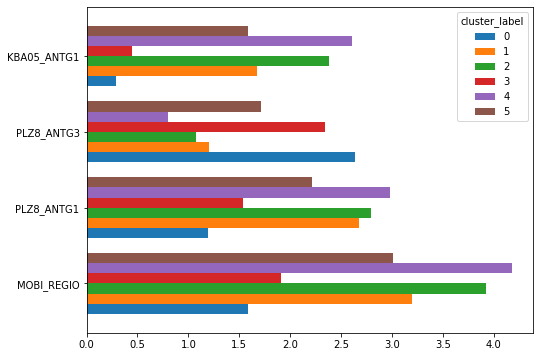

In [58]:
plt.rcParams['figure.figsize'] = (8, 6)
azdias[["MOBI_REGIO", "PLZ8_ANTG1", "PLZ8_ANTG3", "KBA05_ANTG1", "cluster_label"]].groupby(by="cluster_label").mean().T.plot.barh(width=0.8)

Cluster 1, 2, 4 have higher share of 1-2 family houses in the cell. 
Cluster 0, 3, 5 have higher share of 6-10 family houses in the PLZ8. 
Cluster 1, 2, 4 have lower mobility.

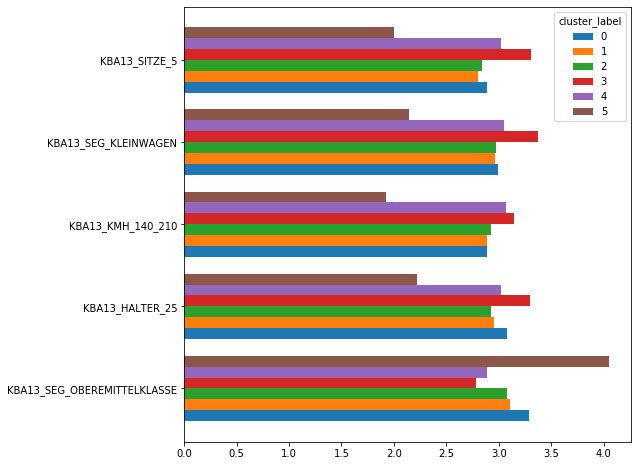

In [60]:
plt.rcParams['figure.figsize'] = (8, 8)
azdias[["KBA13_SEG_OBEREMITTELKLASSE", "KBA13_HALTER_25", "KBA13_KMH_140_210", "KBA13_SEG_KLEINWAGEN", "KBA13_SITZE_5", "cluster_label"]].groupby(by="cluster_label").mean().T.plot.barh(width=0.8)

Cluster 5 have higher share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.), lower share of car owners between 21 and 25 within the PLZ8, lower share of cars with max speed between 140 and 210 km/h within the PLZ8, smaller number of cars with 5 seats in the PLZ8, and lower share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8.  

Cluster 3 have higher share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8 and larger number of cars with 5 seats in the PLZ8.

Other clusters are relatively the same.

##### Customer behaviors and characteristics
We look at D19_GESAMT_ANZ_24 and ONLINE_AFFINITAET for behaviors; PRAEGENDE_JUGENDJAHRE_decade for age; FINANZ_VORSORGER, FINANZ_UNAUFFAELLIGER, and FINANZ_SPARER for financial typology.

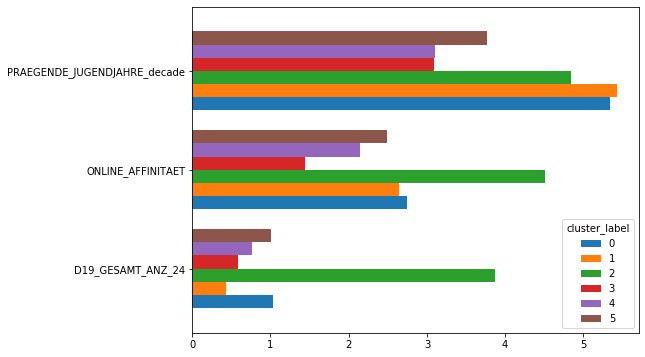

In [61]:
plt.rcParams['figure.figsize'] = (8, 6)
azdias[["D19_GESAMT_ANZ_24", "ONLINE_AFFINITAET", "PRAEGENDE_JUGENDJAHRE_decade", "cluster_label"]].groupby(by="cluster_label").mean().T.plot.barh(width=0.8)

Cluster 0 and 1 have more younger individuals. Cluster 3 and 4 have more older individuals.

Cluster 2 has high online affinity. Cluster 3 has lower online affinity.

Cluster 2 has more frequent activity TOTAL POOL in the last 24 months.

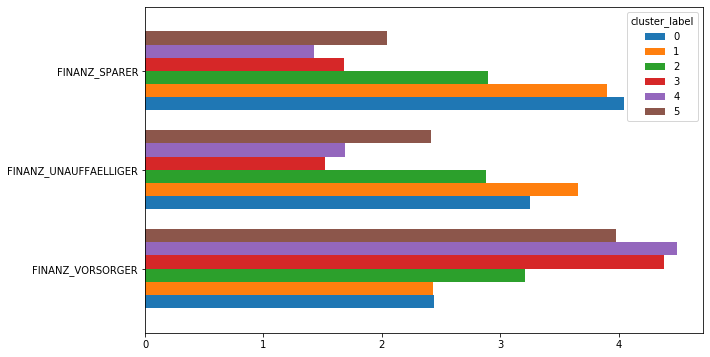

In [63]:
plt.rcParams['figure.figsize'] = (10, 6)
azdias[["FINANZ_VORSORGER", "FINANZ_UNAUFFAELLIGER", "FINANZ_SPARER", "cluster_label"]].groupby(by="cluster_label").mean().T.plot.barh(width=0.8)

FINANZ_VORSORGER measures whether the individual is prepared, FINANZ_UNAUFFAELLIGER means unremarkable, and FINANZ_SPARER measures money saver. 

Cluster 0 and 1 have lower share of money savers, lower share of prepared individuals, and higher share of unremarkable individuals.

Cluster 4 has higher share of money savers.

Cluster 3, 4, and 5 has higher share of prepared individuals.

##### Summary

Base on these features, I summarized the characteristics of 6 clusters as following:
- **Cluster 0:** Younger people who have high mobility and live in 6–10 family houses. They prefer online purchases. Their financial typology is likely to be unremarkable. They are less prepared and do not like to save money. They are highly unlikely to become customers.
- **Cluster 1:** Younger people who have low mobility and live in 1–2 family houses. Similar to Cluster 0, they also prefer online purchases. Their financial typology is likely to be unremarkable. They are less prepared and do not like to save money. They are also highly unlikely to be the customers.
- **Cluster 2:** Younger people who have low mobility and live in 1–2 family houses. They do not prefer online purchases as much as Cluster 0 and 1, but they have a high online affinity and frequent purchase activity in the last 24 months. They are highly likely to be customers.
- **Cluster 3:** Older people who have high mobility and live in 6–10 family houses. They prefer small cars with 5 seats. They do not like online purchases and have a low online affinity. In terms of financial typology, they are prepared. They are less likely to become customers. 
- **Cluster 4:** Older people who have low mobility and live in 1–2 family houses. They do not like online purchases. In terms of financial typology, they are prepared money-savers. They are highly likely to become customers.
- **Cluster 5:** People who have moderate ages and moderate mobility among all clusters and live in 6–10 family houses. They prefer upper or middle class cars. They do not like online purchases. In terms of financial typology, they are prepared. They are also highly likely to become customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv", sep=";")
mailout_train.shape

C:\Users\82151\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 367)

In [5]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

### Preprocess the dataset

#### Clean the data
Before cleaning the train and test dataset, we need to revise the previous clean function so that no rows will be dropped.

In [7]:
# revise the clean function
def clean_dataset_2(df):
    """
    Preprocess the data by dealing with missing values and categorical variables

    INPUT:
    df: DataFrame, the original dataset
    
    OUTPUT:
    cleaned_df: DataFrame, the cleaned dataset
    """

    print("The shape of the original dataset: ", df.shape)
    
    # set LNR to be the index
    df.set_index("LNR", inplace=True)
    
    # Deals with missing values

    # convert all the missing values to np.nan
    # load in the descriptions of each column to see which columns contain "unknown" value
    attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1, usecols = "B:E")
    attributes.ffill(inplace=True)
    unknown_values = attributes.loc[attributes.Meaning.str.contains("unknown")]

    # convert all the "unknown" into np.nan
    for index, row in unknown_values.iterrows():
        attribute = row["Attribute"]
        values = row["Value"]

        value_list = []
        if type(values) != int:
            value_list = values.split(",")
        else:
            value_list.append(values)

        for i in value_list:
            df[attribute] = df[attribute].replace(int(i), np.nan)

    # convert missing values in object data to np.nan
    df["CAMEO_DEU_2015"] = df["CAMEO_DEU_2015"].replace("XX", np.nan)
    df["CAMEO_DEUG_2015"] = df["CAMEO_DEUG_2015"].replace("X", np.nan)
    df["CAMEO_INTL_2015"] = df.CAMEO_INTL_2015.replace("XX", np.nan)

    # ensure the object data is in the right data type
    df.CAMEO_DEUG_2015 = df.CAMEO_DEUG_2015.apply(lambda x: float(x))
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.apply(lambda x: float(x))

    # drop unuseful column with object data
    df.drop("EINGEFUEGT_AM", axis=1, inplace=True)

    # deals with missing values in columns
    df_col_null_prop = round(df.isnull().mean()*100,1).sort_values(ascending=False)
    cols_drop = df_col_null_prop[df_col_null_prop > 35].index
    df.drop(cols_drop, axis=1, inplace=True) # drop columns that have 50% or more missing values

    print("The shape of the dataset after handling NaNs: ", df.shape)


    # Deal with categorical variables

    # separate categorical features into binary and multi-level variables
    cat_columns = '''ANREDE_KZ, CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, D19_KONSUMTYP, \
                    D19_LETZTER_KAUF_BRANCHE, FINANZTYP, GEBAEUDETYP, GFK_URLAUBERTYP, GREEN_AVANTGARDE, HEALTH_TYP, \
                    LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, \
                    LP_STATUS_GROB, NATIONALITAET_KZ, OST_WEST_KZ, PRAEGENDE_JUGENDJAHRE, RETOURTYP_BK_S, SHOPPER_TYP, \
                    SOHO_KZ, VERS_TYP, WOHNLAGE, ZABEOTYP'''
    cat_list = [i.strip(" ") for i in cat_columns.split(",")]

    binary_list = []
    multi_list = []

    for feature in cat_list:
        if len(df[feature].value_counts()) == 2:
            binary_list.append(feature)
        else:
            multi_list.append(feature)

    #re-encode binary variable OST_WEST_KZ
    df["OST_WEST_KZ"] = df.OST_WEST_KZ.map({"W":0, "O":1})

    #separate CAMEO_INTL_2015_household into two variables
    df['CAMEO_INTL_2015_household'] = df.CAMEO_INTL_2015.apply(lambda x: int(str(x)[0]) if len(str(x)) == 4 else np.nan)
    df['CAMEO_INTL_2015_family'] = df.CAMEO_INTL_2015.apply(lambda x: int(str(x)[1]) if len(str(x)) == 4 else np.nan)

    # re-encode GEBAEUDETYP to only include three types
    # 0 for residental building, 1 for mixed building or company building (since there is only one)
    df.GEBAEUDETYP = df.GEBAEUDETYP.map({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 8:1})

    # separate PRAEGENDE_JUGENDJAHRE into two variables
    # 1-6 for 40ies to 90ies
    df["PRAEGENDE_JUGENDJAHRE_decade"] = df.PRAEGENDE_JUGENDJAHRE.map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, \
                                                                       10:5, 11:5, 12:5, 13:5, 14:6, 15:6})
    # 0 for Mainstream, 1 for Avantgarde
    df["PRAEGENDE_JUGENDJAHRE_movement"] = df.PRAEGENDE_JUGENDJAHRE.map({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, \
                                                                         10:0, 11:1, 12:0, 13:1, 14:0, 15:1})

    # separate WOHNLAGE into two variables
    # 0 for non-rural neighbourhood, 1 for rural neighbourhood, "no score calculated" should be treated as missing vlaue
    df["WOHNLAGE_rural"] = df.WOHNLAGE.map({0:np.nan,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    # 1-5 from very good to very poor area, 0 for others
    df["WOHNLAGE_neighbour"] = df.WOHNLAGE.map({0:np.nan,1:1,2:2,3:3,4:4,5:5,7:0,8:0})

    # drop unused columns
    df.drop(["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE", "FINANZTYP", "LP_FAMILIE_FEIN", \
             "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "PRAEGENDE_JUGENDJAHRE", "WOHNLAGE"], 
            axis = 1, inplace = True)

    # get dummy variables for keeped multi-level variables
    keep_list = ['CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', \
                 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']
    df_cat = df[keep_list]
    df_dummy = pd.get_dummies(df_cat, columns = keep_list, prefix = keep_list)

    # combine with the dataset and drop these original categorical variables
    df = pd.concat([df.drop(keep_list, axis=1), df_dummy], axis = 1)

    print("The shape of the dataset after handling categorical variables: ", df.shape)

    return df

In [8]:
mailout_train_cleaned = clean_dataset_2(mailout_train) # clean the train data

The shape of the original dataset:  (42962, 367)
The shape of the dataset after handling NaNs:  (42962, 356)
The shape of the dataset after handling categorical variables:  (42962, 407)


In [9]:
mailout_train_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

In [10]:
# keep a cleaned version for later use
mailout_train_cleaned.to_csv("mailout_train_cleaned.csv")

#### Apply unsupervised learning methods
Impute missing values, standardize, apply PCA, and then apply k-means clustering on the dataset.   

In [11]:
# keep the response separately in variable y
y = mailout_train_cleaned["RESPONSE"]
mailout_train_cleaned.drop(["RESPONSE"], axis=1, inplace=True) # drop response from the train dataset
mailout_train_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KB

In [28]:
# write a function to apply unsupervised learning methods
def unsupervised(df):
    """
    Impute missing values in dataset, standardize the data and apply PCA on the dataset to reduce dimensions. 
    Then segment the dataset into 6 clusters based on azdias
    
    Input:
    df: the dataset to apply the dimensionality reduction and clustering
    
    Output:
    df_transformed: the transformed dataset
    """
    
    azdias_cleaned = pd.read_csv('azdias_cleaned.csv')
    
    # Impute the missing values
    imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    imp_mode.fit(azdias_cleaned)
    azdias_imputed = pd.DataFrame(data = imp_mode.transform(azdias_cleaned), columns = azdias_cleaned.columns)
    
    # apply to the dataset
    df_imputed = pd.DataFrame(data = imp_mode.transform(df), columns = df.columns)
    print("Shape after imputing NaNs: ", df_imputed.shape)

    
    # Standardize the data
    scaler = StandardScaler()
    scaler.fit(azdias_imputed)
    azdias_scaled = pd.DataFrame(data = scaler.transform(azdias_imputed), columns = azdias_imputed.columns)
    
    # apply to the dataset
    df_scaled = pd.DataFrame(data = scaler.transform(df_imputed), columns = df_imputed.columns)
    print("Shape after standardizing: ", df_scaled.shape)

    
    # Apply PCA
    pca = PCA(100)
    pca.fit(azdias_scaled)
    azdias_pca = pd.DataFrame(data = pca.transform(azdias_scaled))
    
    # apply to the dataset
    df_transformed = pd.DataFrame(data = pca.transform(df_scaled), index=df.index)    
    print("Shape after applying PCA: ", df_transformed.shape)
    
    # Cluster the dataset
    kmeans_kwargs = {"init":"random", "n_init":10, "max_iter":300, "random_state":42}
    kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
    kmeans.fit(azdias_pca)
    df_transformed['cluster_label'] = kmeans.predict(df_transformed)   
    print("Shape after clustering: ", df_transformed.shape)
        
    return df_transformed        

In [29]:
# apply on train dataset
mailout_clustered = unsupervised(mailout_train_cleaned)

Shape after imputing NaNs:  (42962, 406)
Shape after standardizing:  (42962, 406)
Shape after applying PCA:  (42962, 100)
Shape after clustering:  (42962, 101)


In [31]:
# add the response variable back to the train dataset
mailout_train_clustered = pd.concat([mailout_clustered, y], axis=1)
mailout_train_clustered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_label,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1763,-4.691307,-5.890521,2.980670,6.825403,-0.654038,-1.372474,3.849402,0.017270,-1.007571,-0.119281,1.234368,-0.394551,0.186444,-0.728192,2.989722,0.277863,1.129299,0.411538,0.491141,-3.186522,-0.676692,0.247790,0.347521,0.287978,-0.986106,0.470003,0.190527,-1.382860,1.128535,-0.670344,1.474426,0.621458,-0.282767,-1.850016,1.273851,2.426281,4.653169,0.933526,-0.627719,0.717858,0.005029,0.402366,-1.598986,-0.163998,0.545750,-0.472234,0.286989,2.411751,0.397215,0.398954,-0.831719,-0.542254,-0.025936,0.318806,0.242291,1.697918,0.256742,0.229389,-0.278199,-0.581289,-1.525250,-0.494195,0.589045,-0.557842,-0.644073,-0.797434,0.255331,-0.127530,-1.023653,-1.897085,-0.886127,-0.308410,-0.670423,-0.481196,0.539277,-0.711609,-0.810127,-0.601076,-2.305638,1.029942,-1.174601,0.194618,1.565024,1.139267,-0.521989,0.846846,2.228989,-0.576970,0.615084,0.991449,0.797053,1.335329,-1.502313,1.194485,0.815421,0.059633,-0.264817,-1.442265,0.901256,-0.930570,3,0
1771,9.702772,0.968588,-3.517908,1.562999,-3.028709,-2.451287,3.814235,-1.654343,1.254486,-0.453518,0.715050,-0.550470,1.566350,1.039381,-3.209064,2.113393,2.982048,-1.387564,-0.912337,-1.257563,-0.268988,0.705229,3.593386,5.214224,5.424880,4.079666,1.679750,-2.559172,-0.112261,0.839421,-1.830095,-2.948172,0.096545,-1.570393,1.419871,-0.544703,-2.539556,1.166477,-0.206032,-1.794691,0.392242,-1.762574,-2.377081,-3.857997,0.394090,-0.892335,-1.935703,0.029144,-1.122190,1.962361,-2.488146,-1.315905,0.382046,-1.490773,-0.415518,0.581131,0.271505,1.584327,-0.939885,-1.112541,0.473236,-1.657889,0.403959,-0.366949,-0.002797,0.023375,1.077268,1.004803,2.332721,1.369055,0.320329,1.095446,-1.226875,0.067244,1.740694,0.850982,0.911207,2.092894,-0.568050,1.215945,-0.596520,-1.162403,-1.548252,1.769367,-0.371379,0.011823,2.638009,1.873621,0.060130,-0.394350,0.917311,1.135211,0.638173,1.377253,0.014770,0.880122,-0.942277,-1.274836,1.300371,-2.732804,2,0
1776,3.862233,-4.674673,-2.586131,6.102555,5.650112,3.496433,-0.560101,-0.411765,-1.301011,4.448233,-0.677849,0.661399,-0.951723,-2.670157,-2.148861,-1.016224,-0.280647,-0.517587,4.141222,-0.132267,0.972470,-1.474343,-0.420545,1.024933,-0.268709,0.991706,0.137212,-1.865356,-1.068530,-2.216814,0.657243,1.471255,0.508455,2.612290,0.329167,1.664043,0.663451,0.662341,-1.504782,-0.307193,2.117059,0.617798,-1.985365,0.455671,1.092040,-0.813468,-1.407268,1.261696,2.251555,0.386843,1.490844,-1.370303,0.007993,-0.843046,-1.257984,-1.188559,0.617914,-1.873211,0.012402,-1.148301,0.216871,3.600766,-0.793618,-0.413086,-1.003692,-0.554277,-0.957234,-1.464829,-0.133955,-0.881422,0.206036,1.791224,2.482814,-0.634278,0.470625,-1.932996,0.330656,2.324417,0.752651,-0.373483,0.816541,-0.795165,-0.597478,0.230708,1.572424,-1.480188,-0.354147,-0.245605,-0.511826,1.600415,-0.522454,-1.098655,0.154097,3.035597,1.772882,-0.073657,-1.140667,-0.545204,-0.265321,-0.309059,4,0
1460,3.388475,-10.065685,10.318256,2.936271,0.160551,-2.039476,-3.820283,0.028651,-1.503256,-1.104267,4.554919,-1.614166,-2.364399,1.093397,-1.557514,0.214569,-0.274681,1.241026,-0.764386,-0.441561,1.371962,-0.853343,1.287197,0.682244,-0.782383,-0.356085,1.486503,0.554511,0.855729,-1.388489,-1.712695,0.215460,-0.231637,1.731699,1.380985,-2.031055,4.041581,-1.129128,-0.643387,-1.649464,1.556229,0.876271,-0.657340,0.284944,-0.255157,-0.545852,-1.584311,0.169526,2.216378,-0.908800,-0.345712,0.262801,-1.599717,0.020267,1.359531,2.425039,-1.932408,-1.128781,-0.127497,1.376165,-1.661401,-0.054100,0.490185,0.889813,-0.297306,-0.068316,-0.510441,2.145878,-0.296167,-0.513840,-0.176207,0.590484,-0.416551,1.0

In [33]:
mailout_train_clustered.shape

(42962, 102)

In [34]:
# keep a clean version for future use
mailout_train_clustered.to_csv("mailout_train_clustered.csv")

### Split the train and test dataset

In [35]:
mailout_train_clustered = pd.read_csv("mailout_train_clustered.csv")
mailout_train_clustered.shape

(42962, 102)

In [42]:
mailout_train_clustered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_label,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1763,-4.691307,-5.890521,2.980670,6.825403,-0.654038,-1.372474,3.849402,0.017270,-1.007571,-0.119281,1.234368,-0.394551,0.186444,-0.728192,2.989722,0.277863,1.129299,0.411538,0.491141,-3.186522,-0.676692,0.247790,0.347521,0.287978,-0.986106,0.470003,0.190527,-1.382860,1.128535,-0.670344,1.474426,0.621458,-0.282767,-1.850016,1.273851,2.426281,4.653169,0.933526,-0.627719,0.717858,0.005029,0.402366,-1.598986,-0.163998,0.545750,-0.472234,0.286989,2.411751,0.397215,0.398954,-0.831719,-0.542254,-0.025936,0.318806,0.242291,1.697918,0.256742,0.229389,-0.278199,-0.581289,-1.525250,-0.494195,0.589045,-0.557842,-0.644073,-0.797434,0.255331,-0.127530,-1.023653,-1.897085,-0.886127,-0.308410,-0.670423,-0.481196,0.539277,-0.711609,-0.810127,-0.601076,-2.305638,1.029942,-1.174601,0.194618,1.565024,1.139267,-0.521989,0.846846,2.228989,-0.576970,0.615084,0.991449,0.797053,1.335329,-1.502313,1.194485,0.815421,0.059633,-0.264817,-1.442265,0.901256,-0.930570,3,0
1771,9.702772,0.968588,-3.517908,1.562999,-3.028709,-2.451287,3.814235,-1.654343,1.254486,-0.453518,0.715050,-0.550470,1.566350,1.039381,-3.209064,2.113393,2.982048,-1.387564,-0.912337,-1.257563,-0.268988,0.705229,3.593386,5.214224,5.424880,4.079666,1.679750,-2.559172,-0.112261,0.839421,-1.830095,-2.948172,0.096545,-1.570393,1.419871,-0.544703,-2.539556,1.166477,-0.206032,-1.794691,0.392242,-1.762574,-2.377081,-3.857997,0.394090,-0.892335,-1.935703,0.029144,-1.122190,1.962361,-2.488146,-1.315905,0.382046,-1.490773,-0.415518,0.581131,0.271505,1.584327,-0.939885,-1.112541,0.473236,-1.657889,0.403959,-0.366949,-0.002797,0.023375,1.077268,1.004803,2.332721,1.369055,0.320329,1.095446,-1.226875,0.067244,1.740694,0.850982,0.911207,2.092894,-0.568050,1.215945,-0.596520,-1.162403,-1.548252,1.769367,-0.371379,0.011823,2.638009,1.873621,0.060130,-0.394350,0.917311,1.135211,0.638173,1.377253,0.014770,0.880122,-0.942277,-1.274836,1.300371,-2.732804,2,0
1776,3.862233,-4.674673,-2.586131,6.102555,5.650112,3.496433,-0.560101,-0.411765,-1.301011,4.448233,-0.677849,0.661399,-0.951723,-2.670157,-2.148861,-1.016224,-0.280647,-0.517587,4.141222,-0.132267,0.972470,-1.474343,-0.420545,1.024933,-0.268709,0.991706,0.137212,-1.865356,-1.068530,-2.216814,0.657243,1.471255,0.508455,2.612290,0.329167,1.664043,0.663451,0.662341,-1.504782,-0.307193,2.117059,0.617798,-1.985365,0.455671,1.092040,-0.813468,-1.407268,1.261696,2.251555,0.386843,1.490844,-1.370303,0.007993,-0.843046,-1.257984,-1.188559,0.617914,-1.873211,0.012402,-1.148301,0.216871,3.600766,-0.793618,-0.413086,-1.003692,-0.554277,-0.957234,-1.464829,-0.133955,-0.881422,0.206036,1.791224,2.482814,-0.634278,0.470625,-1.932996,0.330656,2.324417,0.752651,-0.373483,0.816541,-0.795165,-0.597478,0.230708,1.572424,-1.480188,-0.354147,-0.245605,-0.511826,1.600415,-0.522454,-1.098655,0.154097,3.035597,1.772882,-0.073657,-1.140667,-0.545204,-0.265321,-0.309059,4,0
1460,3.388475,-10.065685,10.318256,2.936271,0.160551,-2.039476,-3.820283,0.028651,-1.503256,-1.104267,4.554919,-1.614166,-2.364399,1.093397,-1.557514,0.214569,-0.274681,1.241026,-0.764386,-0.441561,1.371962,-0.853343,1.287197,0.682244,-0.782383,-0.356085,1.486503,0.554511,0.855729,-1.388489,-1.712695,0.215460,-0.231637,1.731699,1.380985,-2.031055,4.041581,-1.129128,-0.643387,-1.649464,1.556229,0.876271,-0.657340,0.284944,-0.255157,-0.545852,-1.584311,0.169526,2.216378,-0.908800,-0.345712,0.262801,-1.599717,0.020267,1.359531,2.425039,-1.932408,-1.128781,-0.127497,1.376165,-1.661401,-0.054100,0.490185,0.889813,-0.297306,-0.068316,-0.510441,2.145878,-0.296167,-0.513840,-0.176207,0.590484,-0.416551,1.0

In [41]:
# write a function to split the data
def split_train_test(df, test_size):
    """
    Separate the features and resonse, then split the dataset into train and test parts
    
    Input:
    df: the dataset needs to be split
    test_size: the desired proportion of test set
    
    Output:
    X_train, X_test, y_train, y_test: the train and test part of the features and response
    """
    
    X = df.drop(["RESPONSE"], axis=1)
    y = df["RESPONSE"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [77]:
X_train1, X_test1, y_train1, y_test1 = split_train_test(mailout_train_clustered, 0.2)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

(34369, 101) (8593, 101) (34369,) (8593,)


#### Deal with imbalanced issue
Before refining the model, I also consider the imbalanced issue.

In [63]:
mailout_train_clustered["RESPONSE"].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [39]:
mailout_train_clustered["RESPONSE"].value_counts()/mailout_train_clustered.shape[0]

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

The response rate in the train dataset is only 1.2%. This means that our train dataset is highly imbalanced. To solve this issue, we need to remove samples (undersampling) from the majority class ---- the individuals who didn't respond, and add more examples (oversampling) from the minority class ---- the individuals who responded.


In [59]:
# build a function to do Random Undersampling and Oversampling
def resample(df, major_size, minor_size):
    """
    Resample the dataset to solove the imbalanced issue
    
    Input:
    df: DataFrame. the original imbalanced dataset
    major_size: int. The number of rows that are majority class, which is 0 in our case
    minor_size: int. The number of rows that are minority class, which is 1 in our case
    
    Output:
    new_df: DataFrame. the dataset that is balanced
    """
    
    major_class = df[df["RESPONSE"]==0].sample(major_size, replace=False)
    minor_class = df[df["RESPONSE"]==1].sample(minor_size, replace=True)
    new_df = pd.concat([major_class, minor_class])
    
    return new_df

In [80]:
X_train2, X_test2, y_train2, y_test2 = split_train_test(resample(mailout_train_clustered, 3000, 1500), 0.2)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(3600, 101) (900, 101) (3600,) (900,)


### Train and refine the machine learning model

#### Choose algorithm
I tried Logistic Regression, Random Forest, Gradient Boosting Regression, AdaBoost, and XGBoost to predict the response and use AUC to find the model that performs best.

In [78]:
# Write a function to use different algorithms
def train_test(X_train, X_test, y_train, y_test, clf):
    """
    apply algorithm to build model and return the AUC as the metric
    
    Input:
    X_train, X_test, y_train, y_test:
    clf: the algorithm used to build model
    
    Output:
    AUC_score: the AUC score
    """
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    AUC_score = roc_auc_score(y_test, y_pred)
    
    return AUC_score

In [79]:
# without resampling
logit = LogisticRegression(random_state=0)
rf_clf = RandomForestClassifier(random_state=0)
reg = GradientBoostingRegressor(random_state=0)
regr = AdaBoostRegressor(random_state=0)
xgbr = xgb.XGBRegressor(random_state=0)
clf_name = ["Logistic Regression", "Random Forest", "Gradient Boosting Regression", "AdaBoost", "XGBoost"]
clf_list = [logit, rf_clf, reg, regr, xgbr]

for i in range(len(clf_name)):
    print("The AUC for %s is %0.2f" % (clf_name[i], train_test(X_train1, X_test1, y_train1, y_test1, clf_list[i])))

The AUC for Logistic Regression is 0.50
The AUC for Random Forest is 0.50
The AUC for Gradient Boosting Regression is 0.63
The AUC for AdaBoost is 0.50
The AUC for XGBoost is 0.60


In [81]:
# with resampling
for i in range(len(clf_name)):
    print("The AUC for %s is %0.2f" % (clf_name[i], train_test(X_train2, X_test2, y_train2, y_test2, clf_list[i])))

The AUC for Logistic Regression is 0.61
The AUC for Random Forest is 0.91
The AUC for Gradient Boosting Regression is 0.85
The AUC for AdaBoost is 0.63
The AUC for XGBoost is 0.93


Gradient Boosting Regression performs the best without resampling and XGBoost performs best with resampling. I decided to refine my model with these two algorithms.

For resampling part, I also tried different resample size to find the most appropriate one.

In [82]:
for i in [3000, 2500, 2000, 1800]:
    for j in [1800, 1500, 1200, 1000]:
        X_train, X_test, y_train, y_test = split_train_test(resample(mailout_train_clustered, i, j), 0.2)
        print("The AUC for resample size of (%i, %i) is %0.2f" % (i, j, train_test(X_train, X_test, y_train, y_test, xgbr)))

The AUC for resample size of (3000, 1800) is 0.95
The AUC for resample size of (3000, 1500) is 0.93
The AUC for resample size of (3000, 1200) is 0.89
The AUC for resample size of (3000, 1000) is 0.88
The AUC for resample size of (2500, 1800) is 0.93
The AUC for resample size of (2500, 1500) is 0.95
The AUC for resample size of (2500, 1200) is 0.90
The AUC for resample size of (2500, 1000) is 0.85
The AUC for resample size of (2000, 1800) is 0.96
The AUC for resample size of (2000, 1500) is 0.91
The AUC for resample size of (2000, 1200) is 0.87
The AUC for resample size of (2000, 1000) is 0.88
The AUC for resample size of (1800, 1800) is 0.95
The AUC for resample size of (1800, 1500) is 0.93
The AUC for resample size of (1800, 1200) is 0.88
The AUC for resample size of (1800, 1000) is 0.88


The highest AUC is obtained with a majority size of 2000 and a minority size of 1800.

In [83]:
# split with resampling
X_train2, X_test2, y_train2, y_test2 = split_train_test(resample(mailout_train_clustered, 2000, 1800), 0.2)

#### Improve the model
I used grid search to find the parameters that make the model to have the best performance.

In [84]:
# XGBoost with resampling
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'silent': [1],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

train_test(X_train2, X_test2, y_train2, y_test2, xgb_grid) #train_test

Fitting 2 folds for each of 1215 candidates, totalling 2430 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 14.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 26.3min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 44.5min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 69.0min
[Parallel(n_jobs=5)]: Done 2430 out of 2430 | elapsed: 101.5min finished


0.9588194444444444

In [106]:
# refit with the best parameters
parameters = {'colsample_bytree': 1.0, 
              'gamma': 0.5, 'learning_rate': 0.05, 
              'max_depth': 7, 
              'min_child_weight': 10, 
              'n_estimators': 500, 
              'nthread': 4, 
              'objective': 'binary:logistic', 
              'silent': 1, 
              'subsample': 0.8}
xgbr_final1 = xgb.XGBRegressor(verbosity=0, random_state=0, **parameters)
train_test(X_train2, X_test2, y_train2, y_test2, xgbr_final1)

In [110]:
# XGBoost without resampling
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.03, 0.05, 0.07, 0.1], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [1, 5, 10],
              'gamma': [0.2, 0.5, 1, 1.5, 2],
              'silent': [1],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True,
                        scoring = 'roc_auc')

train_test(X_train1, X_test1, y_train1, y_test1, xgb_grid)

Fitting 2 folds for each of 1620 candidates, totalling 3240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 95.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 178.5min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 277.0min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 641.7min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 850.9min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 1100.6min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 1420.4min
[Parallel(n_jobs=5)]: Done 3240 out of 3240 | elapsed: 1454.2min finished


0.6035601619346792

In [111]:
print(xgb_grid.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 500, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.6}


In [112]:
# refit with the best parameters
parameters = {'colsample_bytree': 0.6, 
              'gamma': 0.5, 
              'learning_rate': 0.03, 
              'max_depth': 7, 
              'min_child_weight': 10, 
              'n_estimators': 500, 
              'nthread': 4, 
              'objective': 'binary:logistic', 
              'silent': 1, 
              'subsample': 0.6}
xgbr_final2 = xgb.XGBRegressor(verbosity=0, random_state=0, **parameters)
train_test(X_train1, X_test1, y_train1, y_test1, xgbr_final2)

0.6035601619346792

In [ ]:
# Gradient Boosting Regression without resampling
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]}

reg_grid = GridSearchCV(reg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True,
                        scoring = 'roc_auc')

train_test(X_train1, X_test1, y_train1, y_test1, reg_grid)

In [113]:
parameters = {'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}

reg_final = GradientBoostingRegressor(random_state=0, **parameters)
train_test(X_train1, X_test1, y_train1, y_test1, reg_final)

0.6339957226479567

From the result, I find that even though resampling can lead to a better performance than without resampling, it can easily lead to overfitting, too. Therefore, I reduced the sample size from the minority group and refit the model.

In [ ]:
X_train3, X_test3, y_train3, y_test3 = split_train_test(resample(mailout_train, 2500, 1500), 0.2)

In [ ]:
# XGBoost with resampling
from sklearn.model_selection import GridSearchCV
xgbr = xgb.XGBRegressor(random_state=0)

parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'silent': [1],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

train_test(X_train3, X_test3, y_train3, y_test3, xgb_grid)

In [ ]:
# refit with the best parameters
parameters = {'colsample_bytree': 0.6, 
              'gamma': 0.5, 
              'learning_rate': 0.03, 
              'max_depth': 7, 
              'min_child_weight': 1, 
              'n_estimators': 500, 
              'nthread': 4, 
              'objective': 'binary:logistic', 
              'silent': 1, 
              'subsample': 0.6}
xgbr_final3 = xgb.XGBRegressor(verbosity=0, random_state=0, **parameters) # got AUC score of 0.933567

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [89]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv", sep=";")
mailout_test.shape

C:\Users\82151\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42833, 366)

#### Preprocess the data

In [90]:
mailout_test_cleaned = clean_dataset_2(mailout_test) # clean the test data

The shape of the original dataset:  (42833, 366)
The shape of the dataset after handling NaNs:  (42833, 355)
The shape of the dataset after handling categorical variables:  (42833, 406)


In [91]:
mailout_test_custered = unsupervised(mailout_test_cleaned) # apply unsupervised learning the test data

Shape after imputing NaNs:  (42833, 406)
Shape after standardizing:  (42833, 406)
Shape after applying PCA:  (42833, 100)
Shape after clustering:  (42833, 101)


In [92]:
mailout_test_custered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,cluster_label
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1754,5.799955,-6.078661,6.808267,6.102843,3.123597,3.342060,1.626121,0.168138,-3.484879,0.244391,0.618490,0.243651,-2.641209,-2.849637,2.781832,-2.629580,-1.555425,1.285041,-1.390743,-0.181247,-0.139732,-1.585577,0.200997,-0.202989,0.456045,1.547386,-0.236318,1.769284,0.538587,-0.411082,0.605285,1.550991,1.661407,-0.526372,-0.015419,0.279017,0.662011,-1.221675,-0.344823,1.197724,-0.121200,0.409853,-0.846507,-0.158333,-0.296246,1.609587,-0.782956,-1.104802,-1.514578,0.266290,0.472628,1.735935,1.469907,1.052548,-1.052500,-0.831295,0.199795,-0.933994,1.284975,-0.295516,-0.406232,-1.110054,-0.363912,-0.008151,0.191252,-0.771830,-0.509766,-0.539023,2.325730,0.384991,-0.167199,1.042130,0.950420,-1.242617,-1.399729,-1.080051,-0.751900,0.001836,-0.076733,0.246401,-1.555656,-0.347216,1.446828,0.268011,0.637851,0.847375,0.931056,-1.336112,0.398365,-0.480959,-1.873314,0.002269,-0.880069,-0.283079,-0.510486,1.128675,-1.116753,-1.908305,-0.041303,-0.287868,5
1770,-2.081665,-4.840829,1.202822,3.170994,-1.186595,1.646054,5.120196,-2.008662,1.146255,-1.265847,0.526018,-2.603989,2.096665,0.498544,-2.335911,-2.614247,-0.727863,-2.050854,-1.954774,-0.478247,-0.654278,0.382674,-1.720736,-1.322199,0.578688,1.010152,-2.946354,0.198830,-3.015737,-2.376275,-1.812787,-0.083925,1.559577,-0.096050,-0.919986,0.910972,0.497794,1.882005,-0.397873,-0.144299,0.787638,0.400593,-0.448109,-0.283130,2.394373,-0.486897,-0.175603,1.613263,-1.409009,-0.676753,0.150548,-1.363918,0.663759,1.051561,-0.230545,1.669791,1.218897,-0.275126,-0.736123,0.563182,0.079716,-0.047448,-1.549426,-1.099208,0.119389,1.441202,-1.275265,-1.916548,2.107231,-0.586325,-0.354241,-1.487548,-0.047002,-0.578929,-1.296820,1.506921,-0.174598,-1.622131,-1.120720,-0.015359,0.651233,-1.133194,-1.736694,-0.708798,-0.597360,1.025672,0.568724,-0.382864,0.010298,0.316857,-1.500669,1.484656,-0.054996,1.464188,-1.404851,0.599097,0.539293,0.793110,-1.200872,-0.826906,3
1465,2.246682,-7.216773,2.093320,2.911453,0.112440,-1.378673,-3.096052,4.567111,-1.617409,-0.925240,-3.745145,-0.168668,2.903426,-0.296410,0.427478,3.090429,2.400558,0.129094,-2.876502,1.944068,0.393668,0.691157,0.057352,-1.359293,-0.102029,-0.321634,1.528494,1.135545,3.053903,1.384913,-0.287079,3.508001,0.961725,1.070363,3.058715,-1.542474,0.162705,0.668003,1.525180,-0.549149,-0.800706,-0.381593,-0.052671,-0.647005,0.953554,0.343210,-1.074980,-1.211617,0.287720,0.086729,-1.650727,-2.816463,-1.570518,-1.851750,1.085906,1.221446,0.393825,-0.867440,-0.529160,0.556969,-1.052791,-1.510692,2.571115,-1.290808,-0.878811,0.252886,-0.018977,1.726406,-1.273724,0.074487,-2.449731,-1.422534,1.163010,-0.289660,0.034336,2.478603,0.091811,0.094719,0.700272,0.473656,0.964104,0.548954,0.590930,0.619671,1.402749,-0.241194,0.518821,-0.100350,-0.884045,-0.777844,-0.336832,0.079094,-0.168344,-0.288472,1.992648,0.515560,-0.384415,-0.900093,-1.035566,0.742556,5
1470,1.464301,-5.465401,-6.212416,3.115915,-0.171454,-2.523541,-3.540160,2.087198,-0.217702,1.480339,2.261990,-1.382623,-3.386198,2.329263,-3.588511,-1.160227,-0.039487,-0.953557,0.991217,1.529456,0.709186,0.016314,-1.108744,1.170979,0.983484,0.546549,1.817608,-0.828830,0.491560,-3.574955,1.030113,1.314046,-2.821317,-1.426970,0.723681,-1.585278,0.545604,0.662413,-0.344137,-1.476381,-0.980835,0.531455,-0.924094,0.440445,-0.179671,0.046817,0.185905,3.138450,1.563741,-1.284380,-0.035942,-0.952645,-1.011413,-0.491958,-0.413755,-1.413236,0.864000,-1.232762,2.256981,-1.356444,-2.029849,-0.489051,0.102540,0.417458,-1.724465,-2.498753,-0.102421,0.908393,2.694156,-0.144335,0.343385,1.853407,0.899313,1.391115,2.

In [93]:
mailout_test_custered.to_csv("mailout_test_custered.csv") # keep a cleaned version for later use

#### Predict the response

In [114]:
y_test_pred = xgbr_final3.predict(mailout_test_custered)

In [115]:
df_submit = pd.DataFrame(data=y_test_pred, index=mailout_test_custered.index)
df_submit.rename(columns={0:"RESPONSE"}).to_csv("Kaggle_submit6.csv")